 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from torch import distributions, optim

In [208]:
'''from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')'''

"from google.colab import drive\ndrive.mount('/content/drive')\n\n%cd /content/drive/MyDrive/GitHub/master-thesis\n\nimport sys\nsys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')"

In [209]:
#%cd ..

In [210]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *
from clustering.utils import *

## Optimization Settings

In [211]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 1
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [212]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.0,64.0,4.0
1,2020-08-02,0.0,78.0,2.0
2,2020-08-03,0.0,117.0,7.0


# Experiment Settings

In [213]:
method_type = 'linear'
#method_type = 'nn'

input_type = 'factor_data'
#input_type = 'group_data'
#input_type = 'mobility_data'

# Load Input Data

In [214]:
if input_type == 'factor_data':
  input_data_cols = ['F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/fa_data_model_input.csv', rolling_avg=1, input_data_cols=input_data_cols)

elif input_type == 'group_data':
  input_data_cols = ''
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/group_percentage_non_careful.csv', rolling_avg=7, input_data_cols=None)
elif input_type == 'mobility_data':
  input_data_cols = ['google_workplaces', 'google_residential', 'google_transit'] #['apple_driving', 'apple_walking', 'apple', 'google_retail', 'google_grocery', 'google_workplaces', 'google_residential', 'google_transit', 'google', 'telco', 'applegoogle']
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/mobility_data_denmark.csv', rolling_avg=7, input_data_cols=input_data_cols)
input_data_size = input_data.shape[1]
input_data_size

5

In [215]:
#df_mob = pd.read_csv('data/modeling/mobility_data.csv')
#df_mob.date = pd.to_datetime(df_mob.date, format='%Y-%m-%d')
#df_mob = df_mob[df_mob['region'] == 'denmark'].reset_index(drop=True)
#df_mob.drop(columns=['region'], inplace=True)
#df_mob.to_csv('data/modeling/mobility_data_denmark.csv', index=False)
#df_mob.head()

## Initialize Model Parameter

### Initialize helper parameter

In [216]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [217]:
if method_type == 'linear':
  method = Linear(device=device, dtype=dtype, input_size=input_data_size)
  
elif method_type == 'nn':
  method = NN(device=device, dtype=dtype, input_size=input_data_size)

### Initialize alpha and phi

In [218]:
exp_parameters = pd.read_csv('data/modeling/experiments_estimated_parameters.csv', index_col=0)

In [219]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
#dict_param['real_values']['alpha'] = torch.tensor(exp_parameters.describe()['alpha']['50%'], requires_grad=False, device=device, dtype=dtype)
#dict_param['real_values']['phi'] = torch.tensor(exp_parameters.describe()['phi']['50%'], requires_grad=False, device=device, dtype=dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

# Optimization

## Test Optimization

In [220]:
torch.manual_seed(42)
for i in range(20):
    Linear(device=device, dtype=dtype, input_size=input_data_size).get_parameters()

--------------------
Before Optimization
Metha epoch: 0
Linear Factors: [[ 0.00123934 -0.16640961 -0.03099001 -0.3030452  -0.30696526]]
 Bias: [-0.2609052]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 0:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 1
Linear Factors: [[-0.15308006 -0.35297713  0.37497512 -0.08875582  0.38478112]]
 Bias: [0.13934374]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 1: 100%|██████████| 49/49 [00:02<00:00, 23.99it/s]


After Optimization
Metha epoch: 1
Linear Factors: [[ 0.11892547 -0.06722066  0.66095346  0.18952577  0.6539483 ]]
 Bias: [0.43026537]
 Alpha: 0.048722028732299805
 Phi: 24.88328742980957


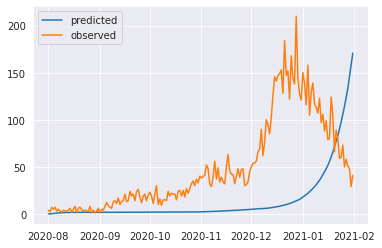

--------------------
Before Optimization
Metha epoch: 2
Linear Factors: [[-0.37869912  0.30948755 -0.1230485  -0.17142862 -0.3712188 ]]
 Bias: [-0.44460216]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 3
Linear Factors: [[ 0.12795256 -0.09769107  0.17411059 -0.36701185  0.3320244 ]]
 Bias: [-0.3282788]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 4
Linear Factors: [[-0.07722186  0.09340937  0.23087482  0.36104015  0.40739337]]
 Bias: [-0.35460556]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 4: 100%|██████████| 49/49 [00:01<00:00, 25.47it/s]


After Optimization
Metha epoch: 4
Linear Factors: [[0.21977513 0.40369955 0.54188824 0.6646859  0.7011402 ]]
 Bias: [-0.04003847]
 Alpha: 0.04786068946123123
 Phi: 24.881702423095703


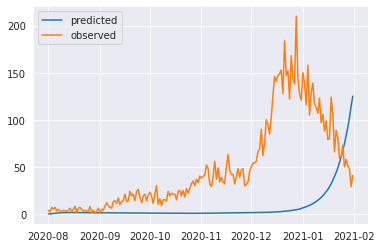

--------------------
Before Optimization
Metha epoch: 5
Linear Factors: [[ 0.11254902 -0.19235817 -0.04900781 -0.33473495  0.40734836]]
 Bias: [-0.32823265]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 6
Linear Factors: [[ 0.23901387  0.15716857  0.1453247  -0.24178432  0.40649548]]
 Bias: [0.09827537]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 6: 100%|██████████| 49/49 [00:01<00:00, 26.45it/s]


After Optimization
Metha epoch: 6
Linear Factors: [[ 0.45170024  0.3927908   0.38279983 -0.01449523  0.6168844 ]]
 Bias: [0.34855464]
 Alpha: 0.04923762381076813
 Phi: 24.88375473022461


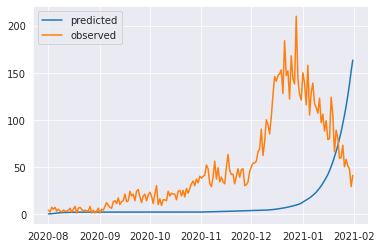

--------------------
Before Optimization
Metha epoch: 7
Linear Factors: [[ 0.05752958 -0.39410913  0.18773511 -0.06709125 -0.2048794 ]]
 Bias: [0.38413256]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 7: 100%|██████████| 49/49 [00:02<00:00, 24.39it/s]


After Optimization
Metha epoch: 7
Linear Factors: [[ 0.3300249  -0.10305851  0.47949845  0.21540247  0.06506103]]
 Bias: [0.68465066]
 Alpha: 0.049394987523555756
 Phi: 24.885761260986328


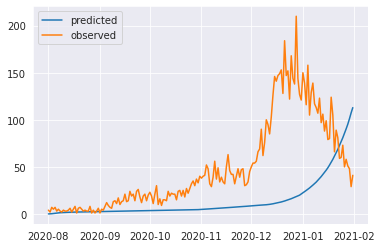

--------------------
Before Optimization
Metha epoch: 8
Linear Factors: [[ 0.09970573 -0.24743274 -0.2263522  -0.02135701  0.24970676]]
 Bias: [-0.1142782]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 8: 100%|██████████| 49/49 [00:01<00:00, 27.36it/s]


After Optimization
Metha epoch: 8
Linear Factors: [[ 0.09970573 -0.24743274 -0.2263522  -0.02135673  0.24970676]]
 Bias: [-0.11427783]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


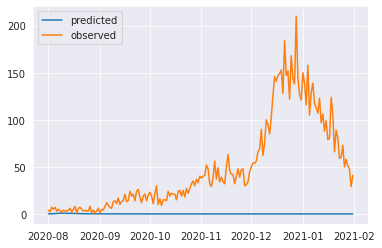

--------------------
Before Optimization
Metha epoch: 9
Linear Factors: [[-0.25516886 -0.1531451  -0.33410203  0.15949088  0.3461613 ]]
 Bias: [-0.42102492]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 10
Linear Factors: [[ 0.10386567  0.23102687  0.08109296 -0.15926377  0.23341961]]
 Bias: [0.23501663]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 10: 100%|██████████| 49/49 [00:01<00:00, 24.88it/s]


After Optimization
Metha epoch: 10
Linear Factors: [[0.2956051  0.451097   0.30380467 0.05167754 0.42342794]]
 Bias: [0.47550523]
 Alpha: 0.04954232648015022
 Phi: 24.88538932800293


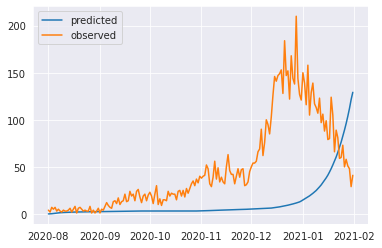

--------------------
Before Optimization
Metha epoch: 11
Linear Factors: [[ 0.16722535 -0.078585   -0.11842272  0.04784332 -0.07900211]]
 Bias: [-0.13327011]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 12
Linear Factors: [[ 0.285862    0.38433516 -0.04427296 -0.10012972  0.00652587]]
 Bias: [-0.02670234]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 12: 100%|██████████| 49/49 [00:01<00:00, 25.78it/s]


After Optimization
Metha epoch: 12
Linear Factors: [[0.5633748  0.6811518  0.25359273 0.18796238 0.28112632]]
 Bias: [0.28005654]
 Alpha: 0.04919734597206116
 Phi: 24.88300895690918


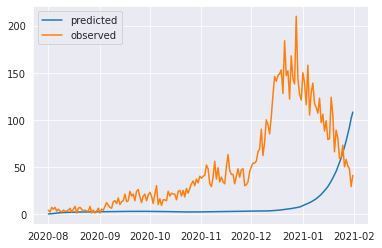

--------------------
Before Optimization
Metha epoch: 13
Linear Factors: [[ 0.10751519  0.12532428 -0.40618476 -0.16503869  0.37661174]]
 Bias: [0.17421427]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 13: 100%|██████████| 49/49 [00:01<00:00, 25.61it/s]


After Optimization
Metha epoch: 13
Linear Factors: [[ 0.38860703  0.4235525  -0.10722185  0.12506194  0.6549922 ]]
 Bias: [0.48091143]
 Alpha: 0.04868136718869209
 Phi: 24.883134841918945


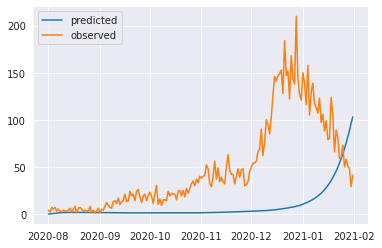

--------------------
Before Optimization
Metha epoch: 14
Linear Factors: [[-0.02224332 -0.26962763 -0.27360755 -0.40059912 -0.14577483]]
 Bias: [0.1510259]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 15
Linear Factors: [[ 0.28515306  0.20647733 -0.39531177 -0.26893747 -0.07057775]]
 Bias: [0.43261185]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 15: 100%|██████████| 49/49 [00:01<00:00, 28.22it/s]


After Optimization
Metha epoch: 15
Linear Factors: [[ 0.5280093   0.47605357 -0.12371194 -0.00903791  0.17029081]]
 Bias: [0.7200363]
 Alpha: 0.04958163574337959
 Phi: 24.886125564575195


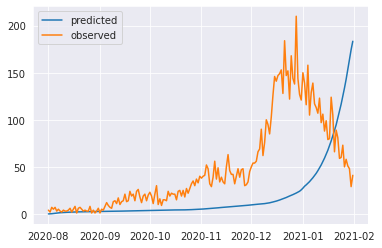

--------------------
Before Optimization
Metha epoch: 16
Linear Factors: [[ 0.0646928  -0.11581523  0.18501908 -0.1703354  -0.28946152]]
 Bias: [0.3264155]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 16: 100%|██████████| 49/49 [00:01<00:00, 27.66it/s]

After Optimization
Metha epoch: 16
Linear Factors: [[ 0.3484353   0.19072571  0.49281886  0.12663594 -0.00823095]]
 Bias: [0.64629394]
 Alpha: 0.049654897302389145
 Phi: 24.885974884033203


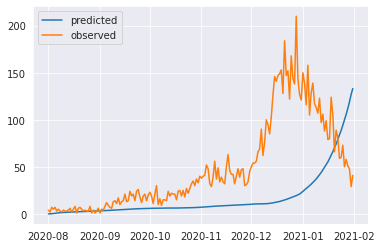

--------------------
Before Optimization
Metha epoch: 17
Linear Factors: [[-0.20334882 -0.08965146 -0.44489     0.29930693  0.3388245 ]]
 Bias: [0.16298619]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 17: 100%|██████████| 49/49 [00:02<00:00, 23.89it/s]


After Optimization
Metha epoch: 17
Linear Factors: [[ 0.08369926  0.21837878 -0.13710739  0.5998148   0.6249229 ]]
 Bias: [0.482459]
 Alpha: 0.048717744648456573
 Phi: 24.88340950012207


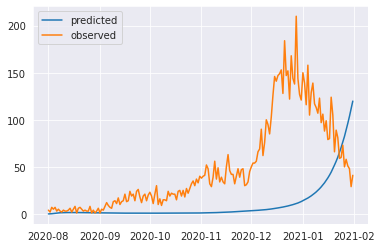

--------------------
Before Optimization
Metha epoch: 18
Linear Factors: [[-0.3118305  -0.44137293 -0.36321747  0.33348727  0.21470982]]
 Bias: [0.37633222]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 18: 100%|██████████| 49/49 [00:01<00:00, 27.61it/s]


After Optimization
Metha epoch: 18
Linear Factors: [[-0.01657476 -0.13238661 -0.0543916   0.6360013   0.50810605]]
 Bias: [0.6903177]
 Alpha: 0.0486406534910202
 Phi: 24.884029388427734


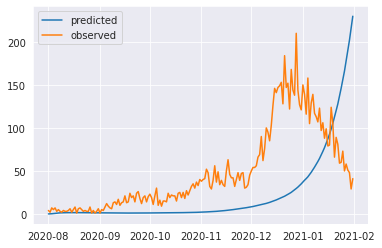

--------------------
Before Optimization
Metha epoch: 19
Linear Factors: [[ 0.23428173  0.11318626 -0.00437942 -0.34010863 -0.38316017]]
 Bias: [-0.41830063]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 20
Linear Factors: [[ 0.18307222 -0.21956755 -0.09000289 -0.25737378 -0.08149285]]
 Bias: [-0.31476453]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 21
Linear Factors: [[-0.29221636  0.14834559 -0.13291027  0.27608427 -0.14347003]]
 Bias: [-0.32806125]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 22
Linear Factors: [[-0.07890589 -0.21678562 -0.13682124 -0.42574537  0.25021195]]
 Bias: [-0.31135213]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 23
Linear Factors: [[ 0.22477747  0.20293847  0.31950402 -0.34303612  0.3216346 ]]
 Bias: [-0.21142095]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 23: 100%|██████████| 49/49 [00:01<00:00, 26.75it/s]


After Optimization
Metha epoch: 23
Linear Factors: [[ 0.5441193   0.5347865   0.6513847  -0.01906464  0.63765186]]
 Bias: [0.12367141]
 Alpha: 0.04855216667056084
 Phi: 24.88177490234375


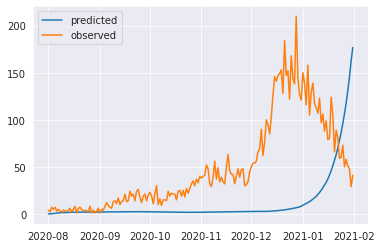

--------------------
Before Optimization
Metha epoch: 24
Linear Factors: [[ 0.16594718  0.41998485 -0.06307136 -0.00345851 -0.10296224]]
 Bias: [-0.37341642]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 25
Linear Factors: [[ 0.21461909 -0.4439569   0.27763015  0.33461642  0.42293274]]
 Bias: [-0.10548854]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 25: 100%|██████████| 49/49 [00:02<00:00, 22.39it/s]


After Optimization
Metha epoch: 25
Linear Factors: [[ 0.45662057 -0.18078618  0.5429357   0.590207    0.6620516 ]]
 Bias: [0.1711934]
 Alpha: 0.04846589267253876
 Phi: 24.882715225219727


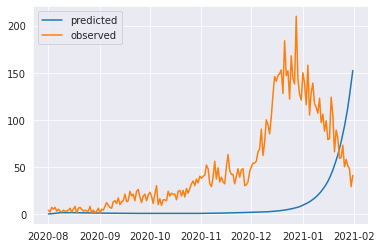

--------------------
Before Optimization
Metha epoch: 26
Linear Factors: [[-0.36744943  0.10054715  0.247053   -0.4451156  -0.10151018]]
 Bias: [-0.26808465]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 26:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 27
Linear Factors: [[-0.03911497 -0.22012456 -0.18280642 -0.14197192 -0.42498887]]
 Bias: [0.3669421]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 27: 100%|██████████| 49/49 [00:01<00:00, 25.69it/s]


After Optimization
Metha epoch: 27
Linear Factors: [[ 0.33330724  0.16895603  0.20648278  0.2380467  -0.05559058]]
 Bias: [0.76278675]
 Alpha: 0.049479808658361435
 Phi: 24.883947372436523


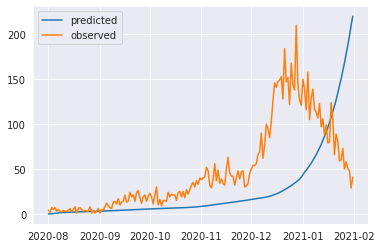

--------------------
Before Optimization
Metha epoch: 28
Linear Factors: [[ 0.37491313 -0.07015397 -0.05092961 -0.18251677 -0.40386197]]
 Bias: [-0.4352034]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 28:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 29
Linear Factors: [[ 0.16621071 -0.2455409  -0.28750333 -0.03489303 -0.14892711]]
 Bias: [-0.14468288]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 29:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 30
Linear Factors: [[ 0.01436951 -0.09485956 -0.1539812  -0.21412851 -0.36395466]]
 Bias: [0.3749918]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 30: 100%|██████████| 49/49 [00:02<00:00, 24.37it/s]


After Optimization
Metha epoch: 30
Linear Factors: [[ 0.35317346  0.26268998  0.20412017  0.13413237 -0.02803593]]
 Bias: [0.74149925]
 Alpha: 0.049610450863838196
 Phi: 24.88469886779785


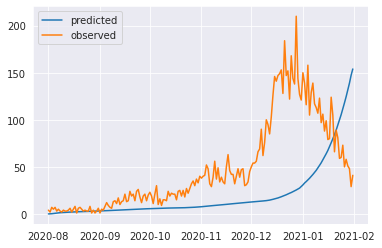

--------------------
Before Optimization
Metha epoch: 31
Linear Factors: [[-0.17896913  0.11850242 -0.15516786  0.03634115  0.41693744]]
 Bias: [0.20604144]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 31: 100%|██████████| 49/49 [00:02<00:00, 24.05it/s]


After Optimization
Metha epoch: 31
Linear Factors: [[0.05883923 0.3774029  0.10515511 0.28694654 0.6524326 ]]
 Bias: [0.47775704]
 Alpha: 0.04908807575702667
 Phi: 24.884429931640625


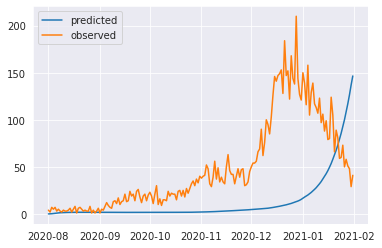

--------------------
Before Optimization
Metha epoch: 32
Linear Factors: [[-0.38755515  0.17750032  0.4245143   0.11765444  0.29982305]]
 Bias: [0.4409023]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 32: 100%|██████████| 49/49 [00:02<00:00, 22.59it/s]


After Optimization
Metha epoch: 32
Linear Factors: [[-0.29600322  0.3058953   0.5572582   0.23784219  0.3927726 ]]
 Bias: [0.6030621]
 Alpha: 0.0497051402926445
 Phi: 24.88998794555664


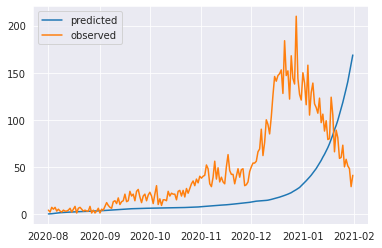

--------------------
Before Optimization
Metha epoch: 33
Linear Factors: [[-0.06852609  0.09282117 -0.31082913 -0.09216048  0.33119914]]
 Bias: [0.22926219]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 33: 100%|██████████| 49/49 [00:02<00:00, 21.80it/s]


After Optimization
Metha epoch: 33
Linear Factors: [[ 0.2034646   0.38550648 -0.01691531  0.19187476  0.60072774]]
 Bias: [0.53395164]
 Alpha: 0.04910801723599434
 Phi: 24.883955001831055


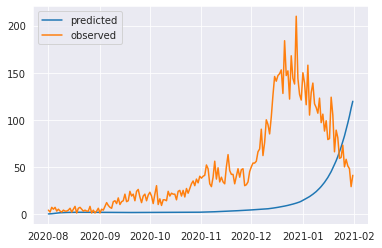

--------------------
Before Optimization
Metha epoch: 34
Linear Factors: [[-0.28299186 -0.35861388 -0.30560952 -0.4413451  -0.34508744]]
 Bias: [-0.11059476]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 34:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 35
Linear Factors: [[ 0.30181423  0.07485561 -0.3401531  -0.35876545  0.2224777 ]]
 Bias: [-0.33265594]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 35:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 36
Linear Factors: [[-0.05506427  0.21453106 -0.20697585 -0.04876412 -0.03892747]]
 Bias: [-0.10580329]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 36:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 37
Linear Factors: [[-0.22675167 -0.39866334 -0.36150825 -0.23946573  0.43193576]]
 Bias: [-0.21601073]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 37:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 38
Linear Factors: [[-0.30031645  0.10840198  0.12325668  0.24503268  0.33993617]]
 Bias: [0.24904169]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 38: 100%|██████████| 49/49 [00:01<00:00, 26.60it/s]


After Optimization
Metha epoch: 38
Linear Factors: [[-0.13094087  0.30569032  0.32327566  0.43399832  0.508132  ]]
 Bias: [0.46758166]
 Alpha: 0.04944914951920509
 Phi: 24.88636016845703


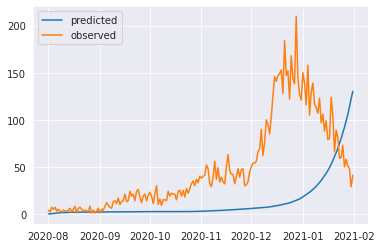

--------------------
Before Optimization
Metha epoch: 39
Linear Factors: [[-0.44341272  0.03966275  0.270901   -0.04133392 -0.26353365]]
 Bias: [0.4263465]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 39: 100%|██████████| 49/49 [00:01<00:00, 26.36it/s]


After Optimization
Metha epoch: 39
Linear Factors: [[-0.17653106  0.32394227  0.55580646  0.23491083  0.00080761]]
 Bias: [0.71921057]
 Alpha: 0.049802228808403015
 Phi: 24.88849639892578


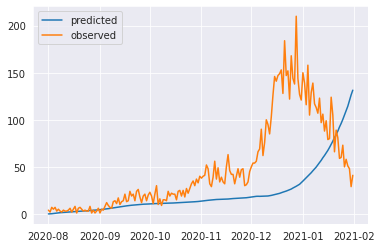

--------------------
Before Optimization
Metha epoch: 40
Linear Factors: [[-0.16727033 -0.25461861 -0.40318766  0.01997628  0.19817515]]
 Bias: [0.09899647]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 40: 100%|██████████| 49/49 [00:02<00:00, 24.16it/s]


After Optimization
Metha epoch: 40
Linear Factors: [[ 0.22328469  0.14699455 -0.00322883  0.4172374   0.5884831 ]]
 Bias: [0.5050708]
 Alpha: 0.04763514921069145
 Phi: 24.881065368652344


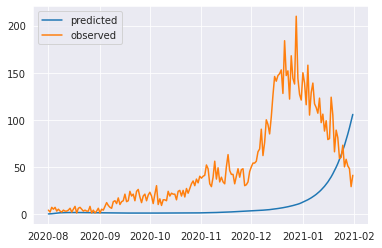

--------------------
Before Optimization
Metha epoch: 41
Linear Factors: [[ 0.08843637 -0.3391612  -0.41764706  0.00787514  0.4077846 ]]
 Bias: [0.25800708]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 41: 100%|██████████| 49/49 [00:01<00:00, 26.35it/s]


After Optimization
Metha epoch: 41
Linear Factors: [[ 0.38074115 -0.03155766 -0.11088698  0.30938676  0.6998814 ]]
 Bias: [0.57184756]
 Alpha: 0.048234499990940094
 Phi: 24.882734298706055


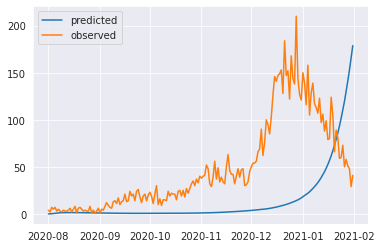

--------------------
Before Optimization
Metha epoch: 42
Linear Factors: [[-0.26038307 -0.05805214 -0.3296785  -0.21574631  0.08098964]]
 Bias: [0.24352501]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 42: 100%|██████████| 49/49 [00:01<00:00, 25.19it/s]


After Optimization
Metha epoch: 42
Linear Factors: [[0.11453424 0.3367899  0.06398346 0.16826189 0.45771745]]
 Bias: [0.644268]
 Alpha: 0.04906974360346794
 Phi: 24.882707595825195


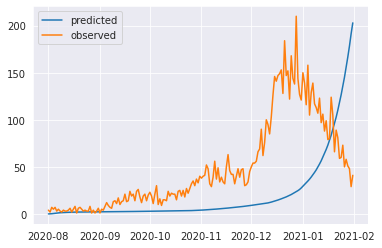

--------------------
Before Optimization
Metha epoch: 43
Linear Factors: [[ 0.37045798 -0.41058952  0.29901382 -0.31541622  0.16746685]]
 Bias: [0.3784524]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 43: 100%|██████████| 49/49 [00:02<00:00, 24.29it/s]


After Optimization
Metha epoch: 43
Linear Factors: [[ 0.5749516  -0.18098791  0.5305977  -0.09449015  0.3701776 ]]
 Bias: [0.6250141]
 Alpha: 0.04941911995410919
 Phi: 24.885662078857422


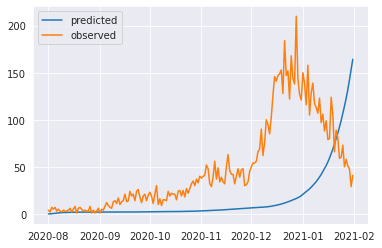

--------------------
Before Optimization
Metha epoch: 44
Linear Factors: [[ 0.00627994  0.40687895 -0.381049   -0.17081735  0.26083863]]
 Bias: [-0.09743346]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 44: 100%|██████████| 49/49 [00:01<00:00, 25.47it/s]


After Optimization
Metha epoch: 44
Linear Factors: [[3.7222469e-01 7.8979158e-01 4.9437175e-04 1.9223623e-01 6.2911367e-01]]
 Bias: [0.2871871]
 Alpha: 0.04822607710957527
 Phi: 24.881540298461914


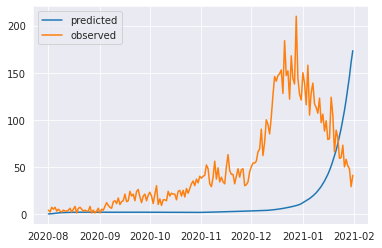

--------------------
Before Optimization
Metha epoch: 45
Linear Factors: [[-0.09154473 -0.1863949   0.3082671   0.2193597   0.14330962]]
 Bias: [-0.2513178]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 45: 100%|██████████| 49/49 [00:01<00:00, 25.27it/s]


After Optimization
Metha epoch: 45
Linear Factors: [[0.2645348  0.18286678 0.6789529  0.58267885 0.49588048]]
 Bias: [0.12244116]
 Alpha: 0.0482652373611927
 Phi: 24.88141632080078


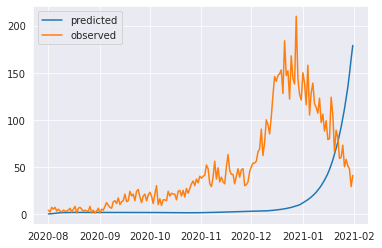

--------------------
Before Optimization
Metha epoch: 46
Linear Factors: [[-0.36302546  0.0483709   0.13249992 -0.20648383 -0.12512933]]
 Bias: [0.30203363]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 46: 100%|██████████| 49/49 [00:02<00:00, 23.55it/s]


After Optimization
Metha epoch: 46
Linear Factors: [[-0.03443091  0.3900523   0.4740656   0.12717496  0.20015267]]
 Bias: [0.6470749]
 Alpha: 0.049492787569761276
 Phi: 24.884349822998047


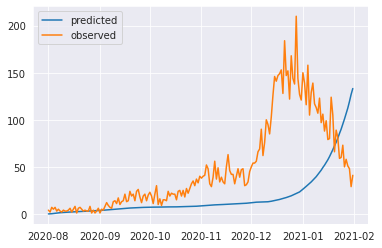

--------------------
Before Optimization
Metha epoch: 47
Linear Factors: [[ 0.0356249   0.02017753 -0.11005951 -0.404992   -0.4204959 ]]
 Bias: [-0.21377483]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 47:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 48
Linear Factors: [[-0.22732824  0.139331   -0.13018869 -0.17495985  0.42638677]]
 Bias: [0.15577473]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 48: 100%|██████████| 49/49 [00:01<00:00, 25.69it/s]


After Optimization
Metha epoch: 48
Linear Factors: [[0.05760275 0.44666043 0.17863147 0.1233851  0.7088227 ]]
 Bias: [0.4768183]
 Alpha: 0.04926447197794914
 Phi: 24.883769989013672


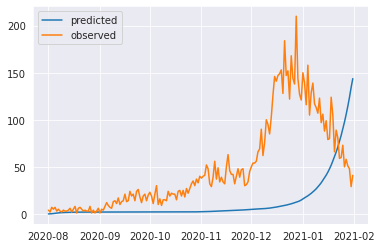

--------------------
Before Optimization
Metha epoch: 49
Linear Factors: [[ 0.3188196  -0.2165018  -0.1826719   0.16436909 -0.29796728]]
 Bias: [-0.29234535]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 49:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 50
Linear Factors: [[-0.02160027 -0.16357315 -0.33525723  0.26526874  0.35963255]]
 Bias: [0.07254848]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 50: 100%|██████████| 49/49 [00:02<00:00, 23.74it/s]


After Optimization
Metha epoch: 50
Linear Factors: [[ 0.27912822  0.14950866 -0.02413359  0.5728359   0.6597234 ]]
 Bias: [0.38869235]
 Alpha: 0.04759171977639198
 Phi: 24.882030487060547


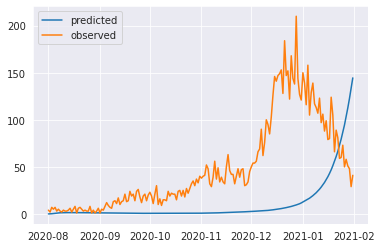

--------------------
Before Optimization
Metha epoch: 51
Linear Factors: [[-0.07786582 -0.41424188 -0.16289252  0.11385415  0.21087503]]
 Bias: [-0.05653563]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 51: 100%|██████████| 49/49 [00:02<00:00, 24.22it/s]


After Optimization
Metha epoch: 51
Linear Factors: [[-0.0778629  -0.41424188 -0.16289106  0.11385852  0.21087871]]
 Bias: [-0.05652909]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


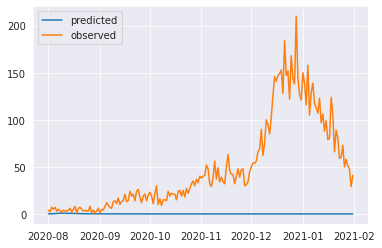

--------------------
Before Optimization
Metha epoch: 52
Linear Factors: [[-0.17680717  0.24919906 -0.35616076  0.282647   -0.17349868]]
 Bias: [0.00684478]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 52: 100%|██████████| 49/49 [00:02<00:00, 23.98it/s]


After Optimization
Metha epoch: 52
Linear Factors: [[0.18027198 0.61882585 0.01168012 0.6448074  0.18036221]]
 Bias: [0.3791059]
 Alpha: 0.048490822315216064
 Phi: 24.88211441040039


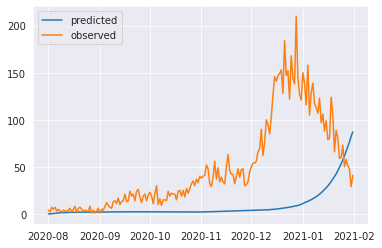

--------------------
Before Optimization
Metha epoch: 53
Linear Factors: [[-0.0883765   0.0542197  -0.13514723  0.32518107 -0.01162628]]
 Bias: [0.3490947]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 53: 100%|██████████| 49/49 [00:01<00:00, 24.66it/s]

After Optimization
Metha epoch: 53
Linear Factors: [[0.10058633 0.27259237 0.08592492 0.5344422  0.17616671]]
 Bias: [0.58955526]
 Alpha: 0.04957633838057518
 Phi: 24.887306213378906


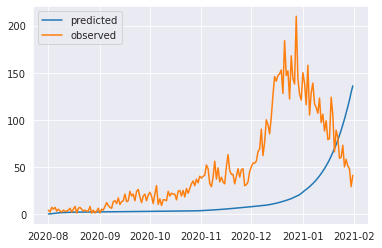

--------------------
Before Optimization
Metha epoch: 54
Linear Factors: [[ 0.42998713 -0.21787842 -0.32624638  0.35880035  0.3504428 ]]
 Bias: [-0.34146872]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 54: 100%|██████████| 49/49 [00:01<00:00, 27.07it/s]


After Optimization
Metha epoch: 54
Linear Factors: [[0.7862306  0.14108068 0.03227296 0.71475345 0.70360863]]
 Bias: [0.01930053]
 Alpha: 0.04444024711847305
 Phi: 24.880544662475586


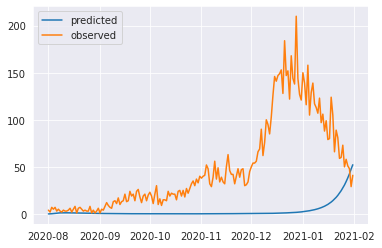

--------------------
Before Optimization
Metha epoch: 55
Linear Factors: [[-0.03457108 -0.44100907 -0.36608866  0.08637597  0.11897429]]
 Bias: [0.09480081]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 55: 100%|██████████| 49/49 [00:01<00:00, 25.09it/s]


After Optimization
Metha epoch: 55
Linear Factors: [[ 0.35041025 -0.04955538  0.0240585   0.4750892   0.5044726 ]]
 Bias: [0.48920146]
 Alpha: 0.04614773020148277
 Phi: 24.880779266357422


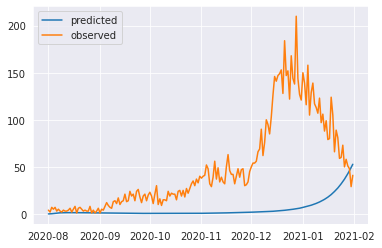

--------------------
Before Optimization
Metha epoch: 56
Linear Factors: [[-0.12171575  0.4125893   0.06394169 -0.26389393 -0.02531846]]
 Bias: [0.1073962]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 56: 100%|██████████| 49/49 [00:01<00:00, 24.91it/s]


After Optimization
Metha epoch: 56
Linear Factors: [[0.17987019 0.7339258  0.38615525 0.04806734 0.27313787]]
 Bias: [0.43843907]
 Alpha: 0.049622565507888794
 Phi: 24.883930206298828


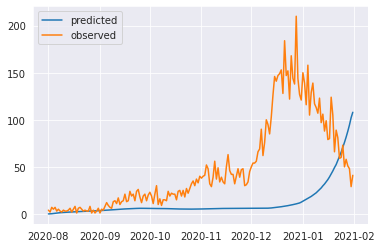

--------------------
Before Optimization
Metha epoch: 57
Linear Factors: [[ 0.15661092 -0.31621617  0.167611   -0.22847322 -0.3716078 ]]
 Bias: [-0.24427138]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 57:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 58
Linear Factors: [[0.43129697 0.382304   0.40047282 0.2625194  0.3378473 ]]
 Bias: [-0.05985942]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 58: 100%|██████████| 49/49 [00:01<00:00, 24.97it/s]


After Optimization
Metha epoch: 58
Linear Factors: [[0.5303963  0.50290686 0.5237469  0.37785226 0.43654156]]
 Bias: [0.07804307]
 Alpha: 0.04921308159828186
 Phi: 24.88319206237793


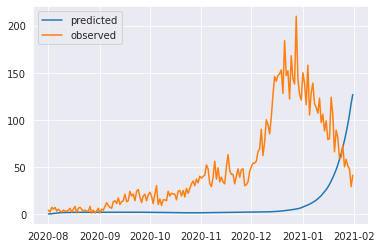

--------------------
Before Optimization
Metha epoch: 59
Linear Factors: [[-0.24606939  0.22345321 -0.23173837 -0.30180916 -0.14281052]]
 Bias: [0.09385191]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 59: 100%|██████████| 49/49 [00:01<00:00, 26.93it/s]


After Optimization
Metha epoch: 59
Linear Factors: [[0.17204502 0.65751636 0.20107572 0.10828972 0.27600846]]
 Bias: [0.52896106]
 Alpha: 0.04913457855582237
 Phi: 24.88166618347168


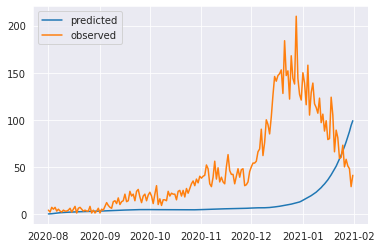

--------------------
Before Optimization
Metha epoch: 60
Linear Factors: [[ 0.23022404 -0.1737018  -0.26321486  0.06032601 -0.26360252]]
 Bias: [-0.2911635]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 60:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 61
Linear Factors: [[ 0.23311093 -0.075125    0.40865707  0.4350416   0.13376406]]
 Bias: [0.153912]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 61: 100%|██████████| 49/49 [00:01<00:00, 26.70it/s]


After Optimization
Metha epoch: 61
Linear Factors: [[0.34910673 0.06200669 0.5481226  0.56659836 0.24940376]]
 Bias: [0.30764252]
 Alpha: 0.04931781440973282
 Phi: 24.884775161743164


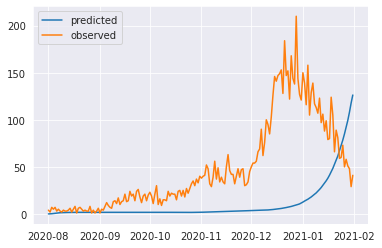

--------------------
Before Optimization
Metha epoch: 62
Linear Factors: [[ 0.10298602  0.00700376 -0.03252694  0.00614656  0.16700064]]
 Bias: [0.41580614]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 62: 100%|██████████| 49/49 [00:01<00:00, 26.37it/s]


After Optimization
Metha epoch: 62
Linear Factors: [[0.27879715 0.20329641 0.16537455 0.19533005 0.34136045]]
 Bias: [0.62566423]
 Alpha: 0.049246903508901596
 Phi: 24.886516571044922


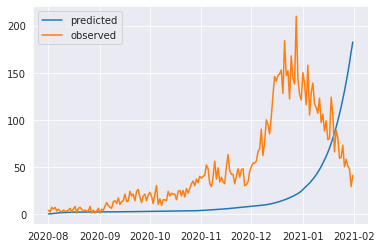

--------------------
Before Optimization
Metha epoch: 63
Linear Factors: [[-0.11589947 -0.18904424 -0.10829941 -0.21605973  0.07604362]]
 Bias: [0.33382186]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 63: 100%|██████████| 49/49 [00:01<00:00, 28.13it/s]


After Optimization
Metha epoch: 63
Linear Factors: [[0.1955264  0.14023888 0.22158721 0.10457032 0.38473657]]
 Bias: [0.6718001]
 Alpha: 0.04930375516414642
 Phi: 24.884279251098633


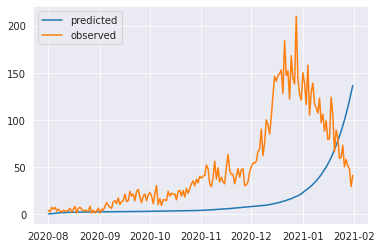

--------------------
Before Optimization
Metha epoch: 64
Linear Factors: [[ 0.34971094  0.20532717 -0.32911858 -0.24002168 -0.09825794]]
 Bias: [-0.08243226]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 64:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 65
Linear Factors: [[ 0.03678231 -0.41052932  0.13919286 -0.34116676 -0.282972  ]]
 Bias: [-0.37180555]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 65:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 66
Linear Factors: [[ 0.389666   -0.42348436  0.33736306 -0.01503394 -0.0520104 ]]
 Bias: [0.27972248]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 66: 100%|██████████| 49/49 [00:01<00:00, 28.77it/s]


After Optimization
Metha epoch: 66
Linear Factors: [[ 0.6048057  -0.1904162   0.57140124  0.21046524  0.1608782 ]]
 Bias: [0.52253044]
 Alpha: 0.04915884509682655
 Phi: 24.884763717651367


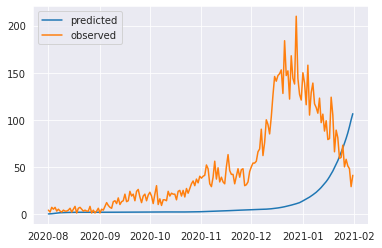

--------------------
Before Optimization
Metha epoch: 67
Linear Factors: [[-0.04133488  0.28047183  0.3233421  -0.38827536  0.17208062]]
 Bias: [0.08442453]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 67: 100%|██████████| 49/49 [00:01<00:00, 27.24it/s]


After Optimization
Metha epoch: 67
Linear Factors: [[ 0.23210017  0.5725117   0.6162176  -0.10503668  0.44243953]]
 Bias: [0.38537264]
 Alpha: 0.049487244337797165
 Phi: 24.883901596069336


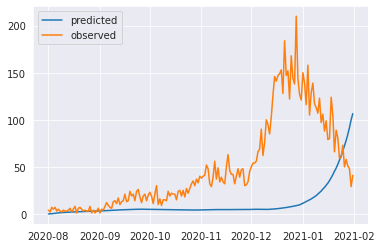

--------------------
Before Optimization
Metha epoch: 68
Linear Factors: [[ 0.09615617  0.06528936  0.12232676 -0.21513963 -0.05721701]]
 Bias: [0.42490655]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 68: 100%|██████████| 49/49 [00:01<00:00, 25.88it/s]


After Optimization
Metha epoch: 68
Linear Factors: [[0.30759302 0.29986265 0.35856473 0.01092241 0.15236919]]
 Bias: [0.67444]
 Alpha: 0.04963016137480736
 Phi: 24.887544631958008


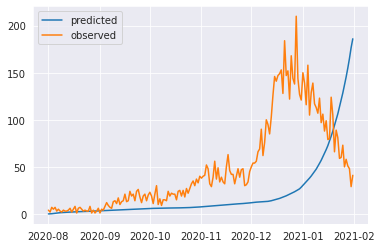

--------------------
Before Optimization
Metha epoch: 69
Linear Factors: [[ 0.30046022 -0.01680112 -0.4206182   0.01960037 -0.3045406 ]]
 Bias: [0.36367032]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 69: 100%|██████████| 49/49 [00:01<00:00, 24.95it/s]


After Optimization
Metha epoch: 69
Linear Factors: [[ 0.58284146  0.28924903 -0.11309314  0.31614104 -0.02441295]]
 Bias: [0.6842821]
 Alpha: 0.04943599924445152
 Phi: 24.88514518737793


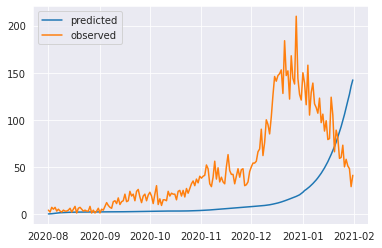

--------------------
Before Optimization
Metha epoch: 70
Linear Factors: [[-0.27149773 -0.03228954 -0.09925578  0.07958338  0.42084035]]
 Bias: [0.04249389]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 70: 100%|██████████| 49/49 [00:01<00:00, 26.11it/s]


After Optimization
Metha epoch: 70
Linear Factors: [[0.03290312 0.28876218 0.22138889 0.39179355 0.7250894 ]]
 Bias: [0.3691105]
 Alpha: 0.048459041863679886
 Phi: 24.8826847076416


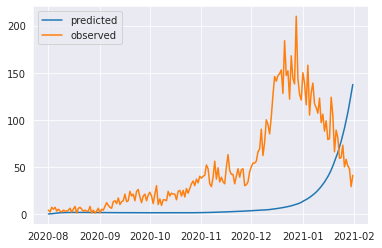

--------------------
Before Optimization
Metha epoch: 71
Linear Factors: [[ 0.25901002  0.34713686  0.36104053 -0.15444587 -0.10002229]]
 Bias: [0.21552911]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 71: 100%|██████████| 49/49 [00:01<00:00, 25.19it/s]


After Optimization
Metha epoch: 71
Linear Factors: [[0.43233055 0.5475975  0.5638807  0.03657462 0.07144744]]
 Bias: [0.4344449]
 Alpha: 0.0497443862259388
 Phi: 24.88616371154785


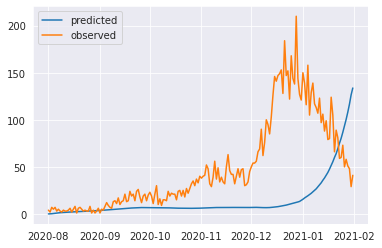

--------------------
Before Optimization
Metha epoch: 72
Linear Factors: [[-0.12203013  0.20941402 -0.09770173 -0.30332366  0.18203531]]
 Bias: [0.06856591]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 72: 100%|██████████| 49/49 [00:01<00:00, 27.74it/s]


After Optimization
Metha epoch: 72
Linear Factors: [[0.21739472 0.5668587  0.26043758 0.04523017 0.5183981 ]]
 Bias: [0.43458232]
 Alpha: 0.049213480204343796
 Phi: 24.882701873779297


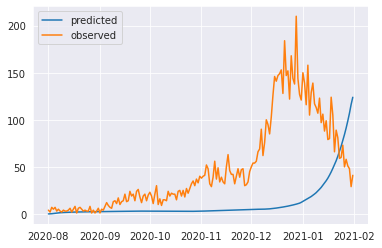

--------------------
Before Optimization
Metha epoch: 73
Linear Factors: [[0.19938944 0.44430047 0.30532745 0.42395005 0.02393614]]
 Bias: [-0.38469875]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 73: 100%|██████████| 49/49 [00:01<00:00, 25.65it/s]


After Optimization
Metha epoch: 73
Linear Factors: [[0.4554719  0.71592987 0.5775921  0.6878437  0.27701938]]
 Bias: [-0.1064287]
 Alpha: 0.04862432926893234
 Phi: 24.882225036621094


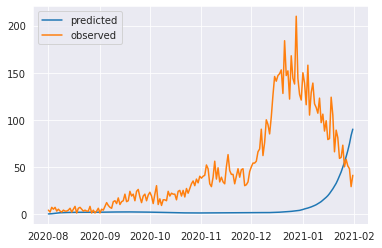

--------------------
Before Optimization
Metha epoch: 74
Linear Factors: [[-0.3137325  -0.27779734 -0.39410624 -0.22416471 -0.4116904 ]]
 Bias: [-0.4126061]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 74:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 75
Linear Factors: [[-0.26723453 -0.4408783  -0.27450526  0.17052642  0.37299976]]
 Bias: [-0.13302942]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 75: 100%|██████████| 49/49 [00:01<00:00, 25.54it/s]


After Optimization
Metha epoch: 75
Linear Factors: [[-0.26723453 -0.4408783  -0.27450526  0.17052642  0.37299976]]
 Bias: [-0.13302942]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


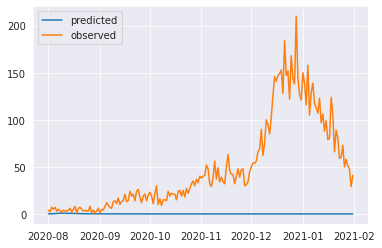

--------------------
Before Optimization
Metha epoch: 76
Linear Factors: [[-0.13008495  0.23879118 -0.22064216 -0.21145715  0.27554148]]
 Bias: [-0.38965794]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 76:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 77
Linear Factors: [[ 0.05468293  0.39506042  0.07669109  0.12161697 -0.26045322]]
 Bias: [-0.00617001]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 77: 100%|██████████| 49/49 [00:02<00:00, 24.31it/s]


After Optimization
Metha epoch: 77
Linear Factors: [[0.34032893 0.6978865  0.38015595 0.41584992 0.02209132]]
 Bias: [0.30422384]
 Alpha: 0.049410589039325714
 Phi: 24.883628845214844


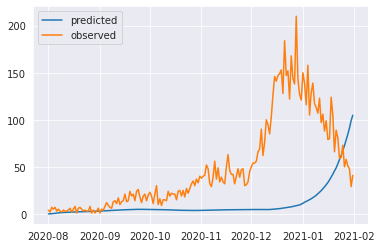

--------------------
Before Optimization
Metha epoch: 78
Linear Factors: [[ 0.02458979  0.10976155  0.17376305  0.38859633 -0.3413579 ]]
 Bias: [0.01340536]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 78: 100%|██████████| 49/49 [00:01<00:00, 25.65it/s]


After Optimization
Metha epoch: 78
Linear Factors: [[ 0.29853553  0.40717223  0.47278267  0.6766132  -0.06992061]]
 Bias: [0.32515264]
 Alpha: 0.04949739947915077
 Phi: 24.884328842163086


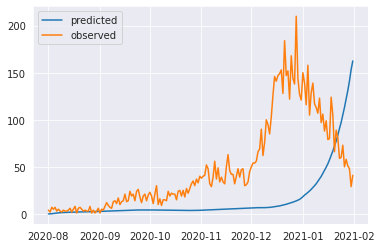

--------------------
Before Optimization
Metha epoch: 79
Linear Factors: [[-0.22344413 -0.35377452 -0.03581181 -0.3936539   0.31211   ]]
 Bias: [0.05179396]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 79:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 80
Linear Factors: [[-0.24102938  0.23370446 -0.42325544 -0.17298187 -0.08712558]]
 Bias: [-0.38001987]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 80:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 81
Linear Factors: [[-0.2843779  -0.07299358  0.33932984  0.4318537   0.2845452 ]]
 Bias: [-0.26704195]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 81: 100%|██████████| 49/49 [00:01<00:00, 25.37it/s]


After Optimization
Metha epoch: 81
Linear Factors: [[0.02108204 0.24887487 0.66289335 0.74729997 0.58764976]]
 Bias: [0.06309623]
 Alpha: 0.04839809238910675
 Phi: 24.88224220275879


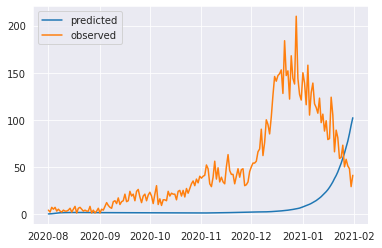

--------------------
Before Optimization
Metha epoch: 82
Linear Factors: [[-0.2925766   0.39028025  0.15818726  0.01188144  0.06052236]]
 Bias: [-0.3594241]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 82: 100%|██████████| 49/49 [00:01<00:00, 28.25it/s]


After Optimization
Metha epoch: 82
Linear Factors: [[0.11522478 0.8191962  0.5863878  0.4196003  0.47292998]]
 Bias: [0.07138874]
 Alpha: 0.04894830659031868
 Phi: 24.881120681762695


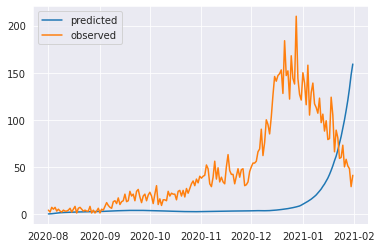

--------------------
Before Optimization
Metha epoch: 83
Linear Factors: [[-0.1493181   0.4304959  -0.11029728 -0.02243407 -0.37133536]]
 Bias: [-0.25017446]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 83:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 84
Linear Factors: [[-0.00913192 -0.27779093 -0.05545878  0.18199767 -0.4374542 ]]
 Bias: [0.13282785]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 84: 100%|██████████| 49/49 [00:01<00:00, 28.27it/s]


After Optimization
Metha epoch: 84
Linear Factors: [[ 0.35598966  0.09766277  0.31968847  0.5508164  -0.07564576]]
 Bias: [0.5092512]
 Alpha: 0.0481976680457592
 Phi: 24.88197898864746


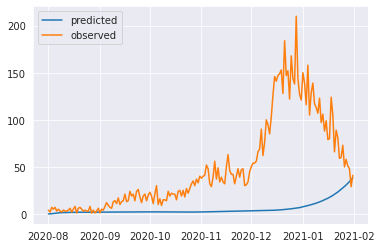

--------------------
Before Optimization
Metha epoch: 85
Linear Factors: [[-0.29570127 -0.21826306  0.17168963  0.3555886  -0.12222733]]
 Bias: [-0.18361206]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 85:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 86
Linear Factors: [[-0.40438655 -0.23060912 -0.39159673 -0.102354    0.09125636]]
 Bias: [-0.41898355]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 86:   0%|          | 0/49 [00:00<?, ?it/s]

Gradient is zero


--------------------
Before Optimization
Metha epoch: 87
Linear Factors: [[ 0.39046824  0.28057772 -0.43779787 -0.21360397  0.14586103]]
 Bias: [-0.09188432]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 87: 100%|██████████| 49/49 [00:01<00:00, 27.79it/s]


After Optimization
Metha epoch: 87
Linear Factors: [[ 0.7519653   0.654241   -0.06583876  0.15219773  0.5027655 ]]
 Bias: [0.28569838]
 Alpha: 0.04818740487098694
 Phi: 24.881380081176758


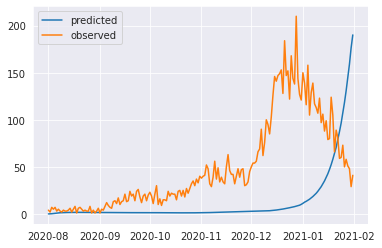

--------------------
Before Optimization
Metha epoch: 88
Linear Factors: [[-0.04873576 -0.20192395  0.3592107  -0.24999161  0.37086385]]
 Bias: [0.02885523]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 88: 100%|██████████| 49/49 [00:03<00:00, 16.10it/s]


After Optimization
Metha epoch: 88
Linear Factors: [[0.24786812 0.11266146 0.6746168  0.0561962  0.66465306]]
 Bias: [0.35254925]
 Alpha: 0.048960234969854355
 Phi: 24.88297462463379


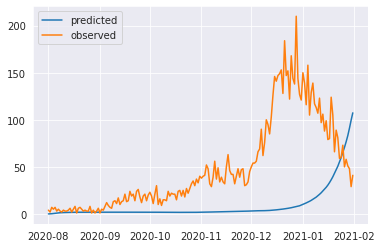

--------------------
Before Optimization
Metha epoch: 89
Linear Factors: [[ 0.08989967  0.34888554 -0.07368542 -0.25461808 -0.07232974]]
 Bias: [0.3627141]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 89: 100%|██████████| 49/49 [00:04<00:00, 10.60it/s]


After Optimization
Metha epoch: 89
Linear Factors: [[ 0.31871727  0.5967452   0.17521302 -0.01493091  0.15402797]]
 Bias: [0.62081933]
 Alpha: 0.04962040111422539
 Phi: 24.886083602905273


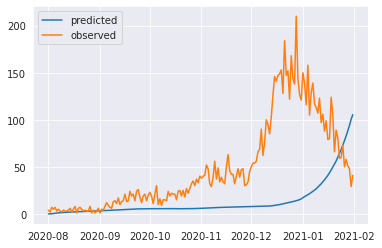

--------------------
Before Optimization
Metha epoch: 90
Linear Factors: [[-0.33182684  0.10150874 -0.43951768  0.23447503  0.16523099]]
 Bias: [0.01895839]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 90: 100%|██████████| 49/49 [00:05<00:00,  9.03it/s]


After Optimization
Metha epoch: 90
Linear Factors: [[ 0.02725803  0.4730753  -0.0707658   0.60071015  0.52324396]]
 Bias: [0.39309028]
 Alpha: 0.04775678366422653
 Phi: 24.88160514831543


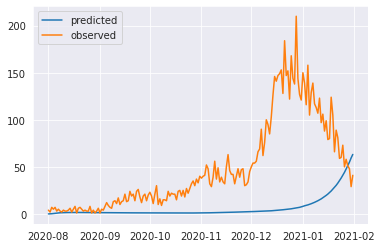

--------------------
Before Optimization
Metha epoch: 91
Linear Factors: [[ 0.19194101  0.000503    0.2474669  -0.35402346 -0.06567443]]
 Bias: [0.19839048]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 91: 100%|██████████| 49/49 [00:03<00:00, 14.24it/s]


After Optimization
Metha epoch: 91
Linear Factors: [[ 0.4814171   0.30444938  0.5516236  -0.05808595  0.22066611]]
 Bias: [0.50734663]
 Alpha: 0.04930252954363823
 Phi: 24.88367462158203


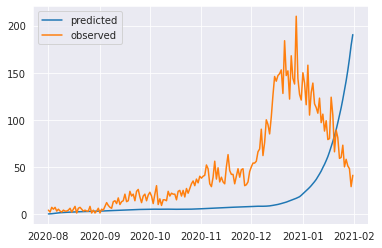

--------------------
Before Optimization
Metha epoch: 92
Linear Factors: [[ 0.4453428   0.22780676 -0.3252023   0.34395057 -0.09972785]]
 Bias: [-0.09548656]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 92: 100%|██████████| 49/49 [00:03<00:00, 14.45it/s]


After Optimization
Metha epoch: 92
Linear Factors: [[ 0.7328272   0.52744013 -0.02593911  0.63663185  0.18450822]]
 Bias: [0.20780803]
 Alpha: 0.04822228103876114
 Phi: 24.882118225097656


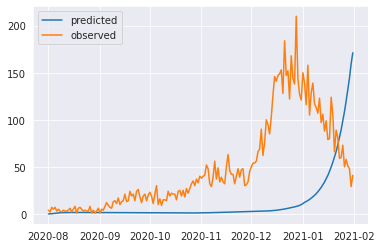

--------------------
Before Optimization
Metha epoch: 93
Linear Factors: [[-0.40647677 -0.07039782  0.31632614  0.06236162 -0.26048133]]
 Bias: [0.13765775]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 93: 100%|██████████| 49/49 [00:03<00:00, 15.34it/s]


After Optimization
Metha epoch: 93
Linear Factors: [[-0.06959911  0.28661403  0.6741241   0.40978867  0.07345952]]
 Bias: [0.50505096]
 Alpha: 0.04969457536935806
 Phi: 24.884376525878906


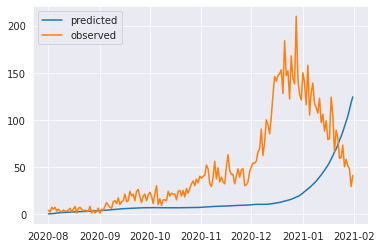

--------------------
Before Optimization
Metha epoch: 94
Linear Factors: [[-0.14339653  0.40830335 -0.3881611  -0.14126383 -0.43181762]]
 Bias: [-0.17612621]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 94:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 95
Linear Factors: [[0.14098303 0.43049437 0.07510789 0.43842962 0.08749829]]
 Bias: [0.25828195]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 95: 100%|██████████| 49/49 [00:03<00:00, 13.88it/s]


After Optimization
Metha epoch: 95
Linear Factors: [[0.22146426 0.5382611  0.18650115 0.54059523 0.16887783]]
 Bias: [0.39091218]
 Alpha: 0.04928603023290634
 Phi: 24.885616302490234


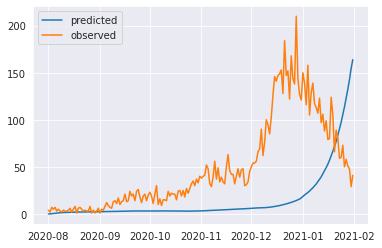

--------------------
Before Optimization
Metha epoch: 96
Linear Factors: [[ 0.35851422  0.37383628 -0.25031605  0.4111637   0.27090654]]
 Bias: [-0.20910768]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 96: 100%|██████████| 49/49 [00:03<00:00, 14.87it/s]


After Optimization
Metha epoch: 96
Linear Factors: [[0.5963337  0.6292795  0.00626625 0.6591438  0.5058599 ]]
 Bias: [0.05589303]
 Alpha: 0.04816732928156853
 Phi: 24.88241958618164


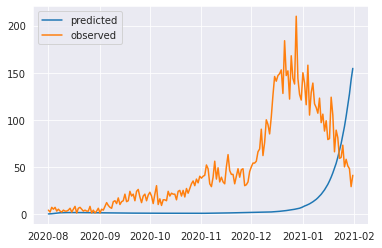

--------------------
Before Optimization
Metha epoch: 97
Linear Factors: [[-0.21341184 -0.3750987   0.112312   -0.36248866  0.18891406]]
 Bias: [0.14122902]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 97: 100%|██████████| 49/49 [00:04<00:00, 11.14it/s]


After Optimization
Metha epoch: 97
Linear Factors: [[0.16675185 0.02161693 0.50981    0.01759049 0.5754676 ]]
 Bias: [0.54147136]
 Alpha: 0.04797245189547539
 Phi: 24.881210327148438


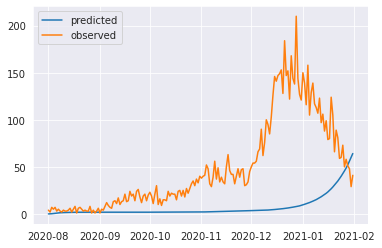

--------------------
Before Optimization
Metha epoch: 98
Linear Factors: [[-0.38854015  0.12186609 -0.03637212  0.2042951   0.25660652]]
 Bias: [-0.44459516]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 98:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 99
Linear Factors: [[ 0.41013908  0.3750521   0.17793898 -0.4087358  -0.15975398]]
 Bias: [-0.12960647]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 99: 100%|██████████| 49/49 [00:04<00:00, 11.79it/s]


After Optimization
Metha epoch: 99
Linear Factors: [[ 0.76045644  0.7374855   0.54010653 -0.05454124  0.18694256]]
 Bias: [0.234673]
 Alpha: 0.04911208152770996
 Phi: 24.88180923461914


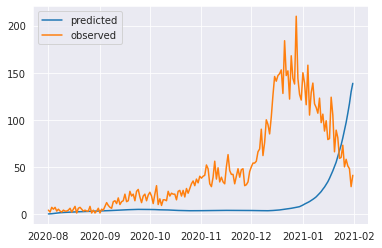

--------------------
Before Optimization
Metha epoch: 100
Linear Factors: [[-0.11493297  0.25219408  0.1625937   0.35427326 -0.16749185]]
 Bias: [0.15050514]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 100: 100%|██████████| 49/49 [00:03<00:00, 13.91it/s]


After Optimization
Metha epoch: 100
Linear Factors: [[0.09218073 0.48700753 0.39985603 0.5797555  0.03785481]]
 Bias: [0.40496498]
 Alpha: 0.04968186467885971
 Phi: 24.88620948791504


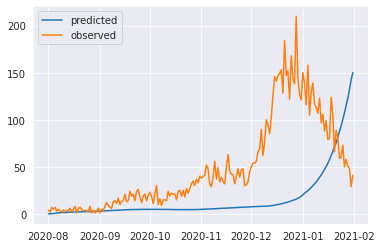

--------------------
Before Optimization
Metha epoch: 101
Linear Factors: [[ 0.15911642 -0.37234592 -0.43380603 -0.23205425  0.30613902]]
 Bias: [-0.42103356]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 101:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 102
Linear Factors: [[-0.38926983  0.25052932  0.24128468  0.3677852  -0.33761886]]
 Bias: [-0.3273155]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 102: 100%|██████████| 49/49 [00:03<00:00, 14.25it/s]


After Optimization
Metha epoch: 102
Linear Factors: [[0.0236555  0.67468464 0.6656745  0.7847242  0.07069449]]
 Bias: [0.0967694]
 Alpha: 0.04886777698993683
 Phi: 24.881168365478516


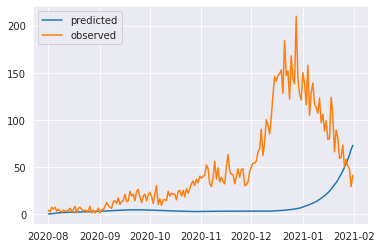

--------------------
Before Optimization
Metha epoch: 103
Linear Factors: [[0.22941461 0.38891044 0.26758525 0.07005695 0.14739029]]
 Bias: [0.42446238]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 103: 100%|██████████| 49/49 [00:03<00:00, 14.19it/s]


After Optimization
Metha epoch: 103
Linear Factors: [[0.26460317 0.46426827 0.34840766 0.13779236 0.1846465 ]]
 Bias: [0.53848094]
 Alpha: 0.04909670352935791
 Phi: 24.885997772216797


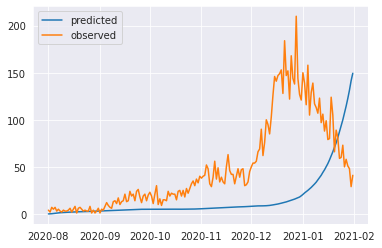

--------------------
Before Optimization
Metha epoch: 104
Linear Factors: [[-0.28854415 -0.20304024  0.31281114 -0.30600125 -0.2465992 ]]
 Bias: [0.32646194]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 104: 100%|██████████| 49/49 [00:03<00:00, 13.36it/s]


After Optimization
Metha epoch: 104
Linear Factors: [[0.06505977 0.16553356 0.6814069  0.05394221 0.1037356 ]]
 Bias: [0.6999201]
 Alpha: 0.04965825006365776
 Phi: 24.884546279907227


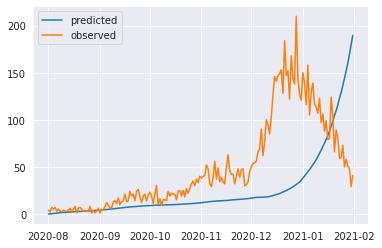

--------------------
Before Optimization
Metha epoch: 105
Linear Factors: [[ 0.14110576  0.14448132 -0.18954718 -0.00617177  0.40930453]]
 Bias: [-0.26842657]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 105: 100%|██████████| 49/49 [00:03<00:00, 13.19it/s]


After Optimization
Metha epoch: 105
Linear Factors: [[ 0.14333792  0.14590283 -0.18801758 -0.00366808  0.41194794]]
 Bias: [-0.26386824]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


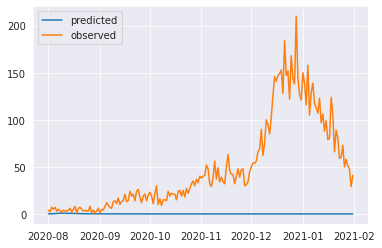

--------------------
Before Optimization
Metha epoch: 106
Linear Factors: [[ 0.00351609  0.21269457 -0.3087367   0.4343235  -0.22343263]]
 Bias: [-0.1073921]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 106: 100%|██████████| 49/49 [00:03<00:00, 14.00it/s]


After Optimization
Metha epoch: 106
Linear Factors: [[0.34783867 0.5736694  0.05073075 0.78835064 0.11941911]]
 Bias: [0.26011124]
 Alpha: 0.0486600399017334
 Phi: 24.882165908813477


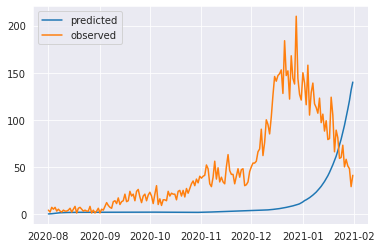

--------------------
Before Optimization
Metha epoch: 107
Linear Factors: [[-0.1210027  -0.2914307  -0.43883485  0.2521621   0.11881308]]
 Bias: [-0.4188606]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 107:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 108
Linear Factors: [[-0.28783867  0.44201162  0.17094071  0.17944206 -0.26756704]]
 Bias: [-0.1960567]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 108: 100%|██████████| 49/49 [00:03<00:00, 13.87it/s]


After Optimization
Metha epoch: 108
Linear Factors: [[0.0724599  0.8132825  0.54174584 0.54262084 0.08904617]]
 Bias: [0.17597514]
 Alpha: 0.04903711751103401
 Phi: 24.88182830810547


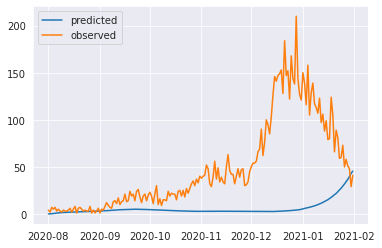

--------------------
Before Optimization
Metha epoch: 109
Linear Factors: [[-0.06750873 -0.08178639 -0.3064524   0.03684366  0.04444766]]
 Bias: [-0.05662664]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 109:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 110
Linear Factors: [[ 0.06199804 -0.17725338  0.11638818  0.16866231 -0.23556484]]
 Bias: [-0.44344762]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 110:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 111
Linear Factors: [[ 0.23408698  0.10667686 -0.22744745  0.43098062 -0.20225143]]
 Bias: [0.30220315]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 111: 100%|██████████| 49/49 [00:04<00:00, 10.48it/s]


After Optimization
Metha epoch: 111
Linear Factors: [[ 0.41143075  0.3123703  -0.01904649  0.627974   -0.02608532]]
 Bias: [0.52901644]
 Alpha: 0.0494510754942894
 Phi: 24.88646125793457


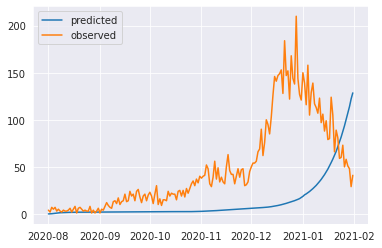

--------------------
Before Optimization
Metha epoch: 112
Linear Factors: [[ 0.2268842  -0.3749475   0.28842652 -0.4112008  -0.24776289]]
 Bias: [-0.07455717]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 112:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 113
Linear Factors: [[-0.30144277  0.43688738 -0.08970194  0.17762865 -0.39932233]]
 Bias: [0.25744584]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 113: 100%|██████████| 49/49 [00:03<00:00, 14.39it/s]


After Optimization
Metha epoch: 113
Linear Factors: [[-0.01030172  0.74289054  0.21657835  0.47568116 -0.11123355]]
 Bias: [0.56891006]
 Alpha: 0.04971303045749664
 Phi: 24.885595321655273


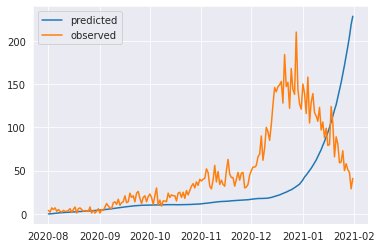

--------------------
Before Optimization
Metha epoch: 114
Linear Factors: [[-0.1389867  -0.3401825   0.06539289  0.21665789  0.38701734]]
 Bias: [-0.27315477]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 114: 100%|██████████| 49/49 [00:03<00:00, 14.36it/s]


After Optimization
Metha epoch: 114
Linear Factors: [[-0.13898379 -0.3401825   0.06539471  0.21666227  0.38702172]]
 Bias: [-0.2731475]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


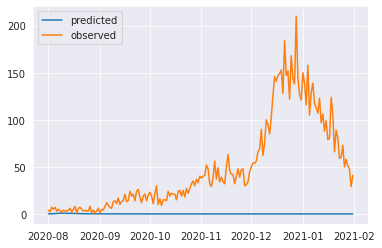

--------------------
Before Optimization
Metha epoch: 115
Linear Factors: [[-0.22007573  0.08598258  0.1213117   0.17194122  0.24546446]]
 Bias: [-0.10140734]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 115: 100%|██████████| 49/49 [00:03<00:00, 13.09it/s]


After Optimization
Metha epoch: 115
Linear Factors: [[0.09694554 0.4149557  0.45021236 0.49346235 0.5593796 ]]
 Bias: [0.2306059]
 Alpha: 0.04844949394464493
 Phi: 24.882123947143555


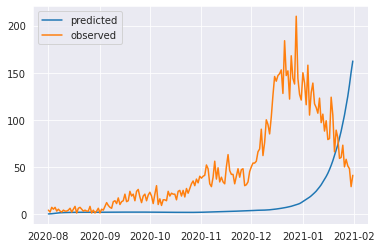

--------------------
Before Optimization
Metha epoch: 116
Linear Factors: [[ 0.2484583   0.32972682 -0.11682182  0.31817335  0.21849939]]
 Bias: [0.39446598]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 116: 100%|██████████| 49/49 [00:03<00:00, 12.48it/s]


After Optimization
Metha epoch: 116
Linear Factors: [[ 0.3011911   0.41977873 -0.02150776  0.40170535  0.2731251 ]]
 Bias: [0.5204109]
 Alpha: 0.04922232776880264
 Phi: 24.88566780090332


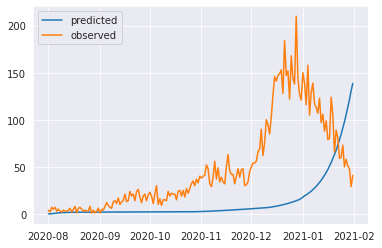

--------------------
Before Optimization
Metha epoch: 117
Linear Factors: [[-0.2541398  -0.22083808 -0.12930685  0.02268549  0.26841715]]
 Bias: [-0.25529754]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 117:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 118
Linear Factors: [[ 0.22389926 -0.16027303  0.2701659  -0.02123247 -0.391798  ]]
 Bias: [-0.24607743]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 118:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 119
Linear Factors: [[-0.32367173  0.22180118 -0.29987827 -0.03726105  0.09648894]]
 Bias: [-0.24524955]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 119:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 120
Linear Factors: [[ 0.12900771 -0.4366698  -0.31998512 -0.4052307  -0.13527198]]
 Bias: [-0.16291875]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 120:   0%|          | 0/49 [00:00<?, ?it/s]

Gradient is zero


--------------------
Before Optimization
Metha epoch: 121
Linear Factors: [[ 0.06403802 -0.08269627  0.21022707  0.41000336  0.16045626]]
 Bias: [-0.17618762]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 121: 100%|██████████| 49/49 [00:03<00:00, 14.46it/s]


After Optimization
Metha epoch: 121
Linear Factors: [[0.3375102  0.21130973 0.50575733 0.69589955 0.43119675]]
 Bias: [0.13014859]
 Alpha: 0.048803240060806274
 Phi: 24.882726669311523


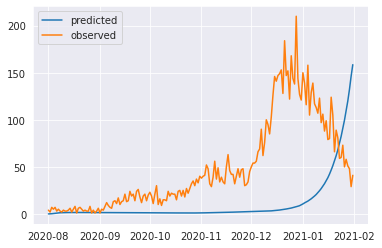

--------------------
Before Optimization
Metha epoch: 122
Linear Factors: [[-0.41876438  0.16198163 -0.2215755   0.2275764   0.29895553]]
 Bias: [0.17249945]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 122: 100%|██████████| 49/49 [00:04<00:00, 10.94it/s]


After Optimization
Metha epoch: 122
Linear Factors: [[-0.15167122  0.44613162  0.06329276  0.5037525   0.5634568 ]]
 Bias: [0.46528083]
 Alpha: 0.048969049006700516
 Phi: 24.88426971435547


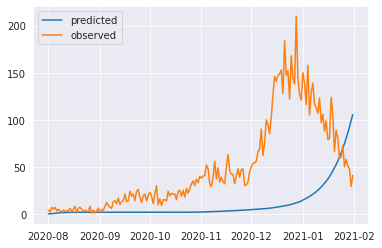

--------------------
Before Optimization
Metha epoch: 123
Linear Factors: [[ 0.4196253   0.42476186  0.09469296 -0.32585624  0.3995591 ]]
 Bias: [-0.21220095]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 123: 100%|██████████| 49/49 [00:03<00:00, 13.13it/s]


After Optimization
Metha epoch: 123
Linear Factors: [[ 0.69678247  0.71840894  0.38907936 -0.04019629  0.6736881 ]]
 Bias: [0.08891313]
 Alpha: 0.04857342690229416
 Phi: 24.882095336914062


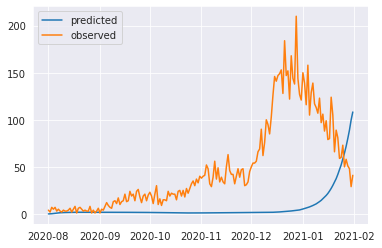

--------------------
Before Optimization
Metha epoch: 124
Linear Factors: [[-0.21124294  0.3742188   0.3465057   0.13512617  0.02803306]]
 Bias: [-0.37618083]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 124: 100%|██████████| 49/49 [00:03<00:00, 14.11it/s]


After Optimization
Metha epoch: 124
Linear Factors: [[0.14762244 0.7493029  0.7222324  0.5005262  0.38376114]]
 Bias: [0.00456354]
 Alpha: 0.04911798983812332
 Phi: 24.881723403930664


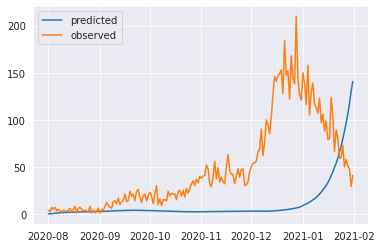

--------------------
Before Optimization
Metha epoch: 125
Linear Factors: [[-0.04642261  0.42893434  0.11388689  0.03828954 -0.09286436]]
 Bias: [-0.15598018]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 125: 100%|██████████| 49/49 [00:03<00:00, 14.73it/s]


After Optimization
Metha epoch: 125
Linear Factors: [[0.28357872 0.7736756  0.45883304 0.37456614 0.23378056]]
 Bias: [0.19365236]
 Alpha: 0.04926099628210068
 Phi: 24.882421493530273


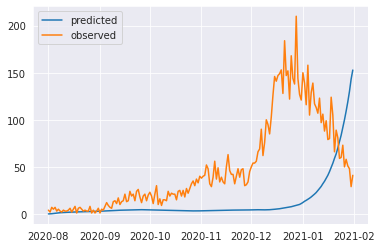

--------------------
Before Optimization
Metha epoch: 126
Linear Factors: [[ 0.26654947  0.027579    0.29094562 -0.07915618  0.19539173]]
 Bias: [0.18459632]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 126: 100%|██████████| 49/49 [00:03<00:00, 15.13it/s]


After Optimization
Metha epoch: 126
Linear Factors: [[0.45452076 0.23294787 0.4974643  0.11926676 0.3812429 ]]
 Bias: [0.39982074]
 Alpha: 0.04908072203397751
 Phi: 24.884328842163086


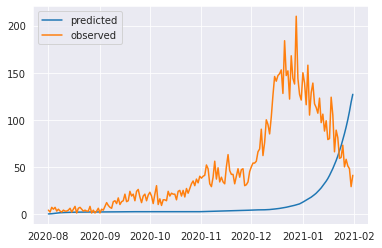

--------------------
Before Optimization
Metha epoch: 127
Linear Factors: [[0.07131452 0.28101695 0.28024456 0.4145327  0.34380704]]
 Bias: [-0.11435102]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 127: 100%|██████████| 49/49 [00:03<00:00, 15.57it/s]


After Optimization
Metha epoch: 127
Linear Factors: [[0.23421355 0.4689408  0.4707674  0.5948389  0.5049417 ]]
 Bias: [0.09172723]
 Alpha: 0.04906826838850975
 Phi: 24.883586883544922


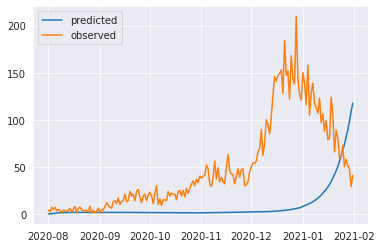

--------------------
Before Optimization
Metha epoch: 128
Linear Factors: [[-0.37862006  0.08175845 -0.0039034  -0.11664466 -0.07488803]]
 Bias: [0.02103372]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 128: 100%|██████████| 49/49 [00:03<00:00, 13.38it/s]


After Optimization
Metha epoch: 128
Linear Factors: [[0.02617628 0.5064754  0.42006093 0.29300633 0.332856  ]]
 Bias: [0.44925815]
 Alpha: 0.049258630722761154
 Phi: 24.88188362121582


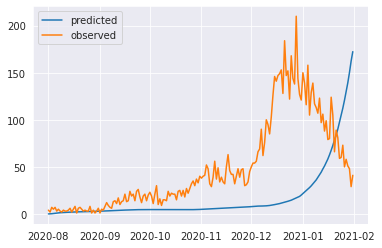

--------------------
Before Optimization
Metha epoch: 129
Linear Factors: [[ 0.32630038  0.13941492 -0.158803   -0.1839054  -0.11074409]]
 Bias: [-0.17284939]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 129:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 130
Linear Factors: [[0.40214467 0.23686458 0.403823   0.00142823 0.09018996]]
 Bias: [0.15507787]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 130: 100%|██████████| 49/49 [00:03<00:00, 14.44it/s]


After Optimization
Metha epoch: 130
Linear Factors: [[0.53247374 0.3905347  0.55984026 0.14791287 0.2194139 ]]
 Bias: [0.32563448]
 Alpha: 0.049552254378795624
 Phi: 24.88481903076172


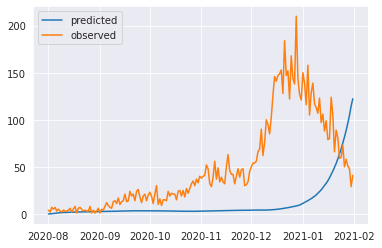

--------------------
Before Optimization
Metha epoch: 131
Linear Factors: [[-0.4233114   0.03993464 -0.02991412 -0.2507321  -0.3470142 ]]
 Bias: [0.39590675]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 131: 100%|██████████| 49/49 [00:03<00:00, 13.68it/s]


After Optimization
Metha epoch: 131
Linear Factors: [[-0.05437495  0.4215753   0.35143945  0.12264505  0.01845791]]
 Bias: [0.7802632]
 Alpha: 0.04965243116021156
 Phi: 24.884639739990234


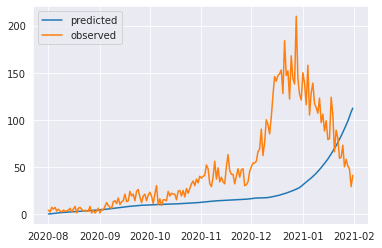

--------------------
Before Optimization
Metha epoch: 132
Linear Factors: [[ 0.36361417  0.20726949  0.42675346 -0.18148279 -0.07724394]]
 Bias: [0.16932338]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 132: 100%|██████████| 49/49 [00:03<00:00, 14.73it/s]


After Optimization
Metha epoch: 132
Linear Factors: [[0.55153847 0.41917136 0.6405784  0.02157877 0.10853691]]
 Bias: [0.39642873]
 Alpha: 0.049571868032217026
 Phi: 24.885276794433594


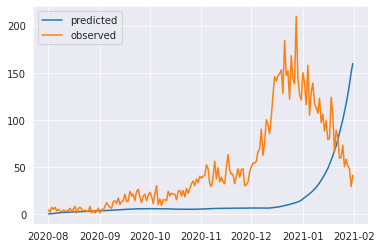

--------------------
Before Optimization
Metha epoch: 133
Linear Factors: [[-0.07389157 -0.08775888 -0.3696495   0.12014896 -0.27026334]]
 Bias: [0.01626347]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 133:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 134
Linear Factors: [[ 0.43602234 -0.13765919 -0.14095803  0.2698097  -0.16441953]]
 Bias: [-0.03840555]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 134: 100%|██████████| 49/49 [00:03<00:00, 14.82it/s]


After Optimization
Metha epoch: 134
Linear Factors: [[0.74606127 0.18503784 0.18179882 0.58567804 0.14144726]]
 Bias: [0.29001585]
 Alpha: 0.04831552878022194
 Phi: 24.882211685180664


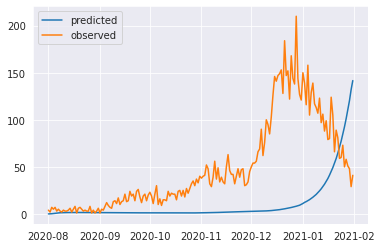

--------------------
Before Optimization
Metha epoch: 135
Linear Factors: [[ 0.41758054 -0.18334582 -0.3199412  -0.2502803  -0.12398802]]
 Bias: [-0.2122023]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 135:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 136
Linear Factors: [[-0.23207332  0.18064946  0.07599846 -0.14313588 -0.34744534]]
 Bias: [-0.14080961]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 136:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 137
Linear Factors: [[-0.18874164 -0.14553177 -0.40344167  0.09634281 -0.32857835]]
 Bias: [-0.34828958]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 137:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 138
Linear Factors: [[-0.36538833  0.18665965 -0.2692345  -0.18458779  0.35054418]]
 Bias: [0.23745443]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 138: 100%|██████████| 49/49 [00:03<00:00, 14.16it/s]


After Optimization
Metha epoch: 138
Linear Factors: [[-0.04784136  0.51706177  0.06115881  0.1381565   0.66505283]]
 Bias: [0.5717288]
 Alpha: 0.04895922914147377
 Phi: 24.883258819580078


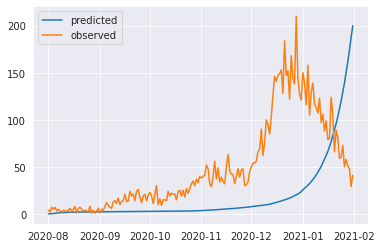

--------------------
Before Optimization
Metha epoch: 139
Linear Factors: [[ 0.25642833 -0.42463222 -0.32069677 -0.16882806  0.36944208]]
 Bias: [0.04575013]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 139: 100%|██████████| 49/49 [00:03<00:00, 13.54it/s]


After Optimization
Metha epoch: 139
Linear Factors: [[ 0.61603004 -0.06255015  0.04060193  0.1905592   0.72632784]]
 Bias: [0.41009337]
 Alpha: 0.045178093016147614
 Phi: 24.88079071044922


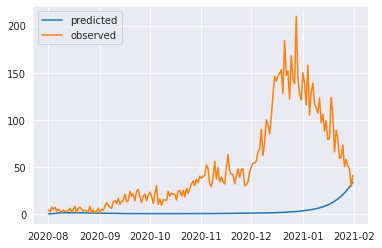

--------------------
Before Optimization
Metha epoch: 140
Linear Factors: [[-0.33446977  0.00280037 -0.34733775 -0.09798418 -0.12297259]]
 Bias: [0.38713565]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 140: 100%|██████████| 49/49 [00:02<00:00, 17.43it/s]


After Optimization
Metha epoch: 140
Linear Factors: [[0.01078472 0.35990098 0.00944448 0.25121987 0.21902227]]
 Bias: [0.746579]
 Alpha: 0.04904165863990784
 Phi: 24.883760452270508


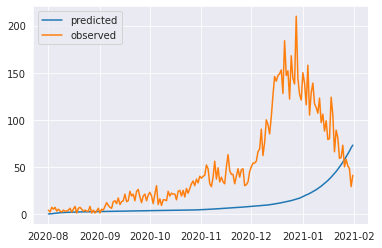

--------------------
Before Optimization
Metha epoch: 141
Linear Factors: [[ 0.13851847 -0.07798114  0.07554723 -0.12909515  0.17571038]]
 Bias: [0.17690152]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 141: 100%|██████████| 49/49 [00:03<00:00, 14.45it/s]


After Optimization
Metha epoch: 141
Linear Factors: [[0.39796886 0.20228145 0.35709763 0.1426106  0.4326813 ]]
 Bias: [0.46930128]
 Alpha: 0.049114521592855453
 Phi: 24.88406753540039


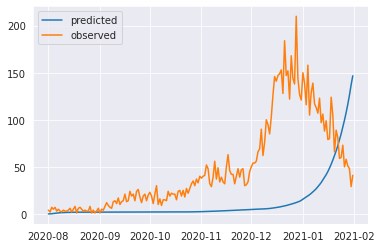

--------------------
Before Optimization
Metha epoch: 142
Linear Factors: [[ 0.12009747 -0.17431355  0.3815406  -0.06456421 -0.17410772]]
 Bias: [0.28009614]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 142: 100%|██████████| 49/49 [00:02<00:00, 16.47it/s]


After Optimization
Metha epoch: 142
Linear Factors: [[0.35574162 0.08721796 0.6449825  0.18747804 0.05948751]]
 Bias: [0.558653]
 Alpha: 0.049702174961566925
 Phi: 24.886276245117188


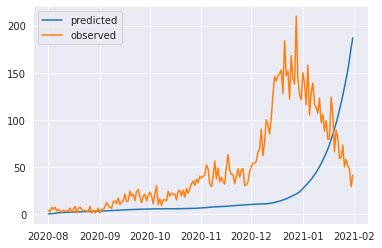

--------------------
Before Optimization
Metha epoch: 143
Linear Factors: [[ 0.36450443  0.44504896  0.13249075 -0.15245236  0.22713621]]
 Bias: [0.38368893]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 143: 100%|██████████| 49/49 [00:03<00:00, 12.60it/s]


After Optimization
Metha epoch: 143
Linear Factors: [[ 0.44654793  0.5523401   0.24290602 -0.05097863  0.3097023 ]]
 Bias: [0.5128885]
 Alpha: 0.049252308905124664
 Phi: 24.885635375976562


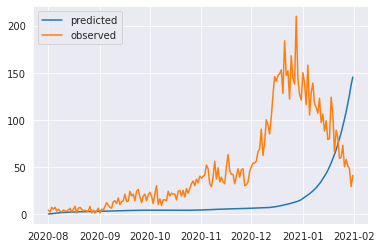

--------------------
Before Optimization
Metha epoch: 144
Linear Factors: [[-0.43864235 -0.05540393 -0.3049842   0.08334262  0.18496075]]
 Bias: [-0.09238892]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 144:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 145
Linear Factors: [[-0.03741261  0.20129566 -0.07516307 -0.3755608   0.3578317 ]]
 Bias: [-0.22508909]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 145:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 146
Linear Factors: [[-0.04913022  0.04218404 -0.02687613 -0.42068756  0.20518158]]
 Bias: [-0.2031385]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 146:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 147
Linear Factors: [[-0.23195162  0.10684624 -0.23338379 -0.20668407 -0.15068859]]
 Bias: [-0.16800812]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 147:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 148
Linear Factors: [[-0.18677315 -0.12060718  0.11621998 -0.36189327 -0.27068958]]
 Bias: [0.0065255]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 148:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 149
Linear Factors: [[ 0.06219316  0.24699269 -0.3141425   0.1427492   0.25419164]]
 Bias: [0.2483199]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 149: 100%|██████████| 49/49 [00:02<00:00, 16.57it/s]


After Optimization
Metha epoch: 149
Linear Factors: [[ 0.2668641   0.4700208  -0.0899223   0.3584123   0.45669487]]
 Bias: [0.4819324]
 Alpha: 0.04908299446105957
 Phi: 24.884532928466797


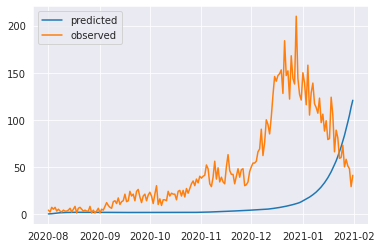

--------------------
Before Optimization
Metha epoch: 150
Linear Factors: [[-0.41654435 -0.17065859 -0.38440943 -0.28300187  0.24909031]]
 Bias: [-0.06677751]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 150:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 151
Linear Factors: [[ 0.18993668 -0.2625172   0.06795853 -0.2705007   0.2235585 ]]
 Bias: [-0.19560184]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 151:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 152
Linear Factors: [[-0.11214289 -0.38801652  0.00147738  0.42462045  0.2170677 ]]
 Bias: [-0.23860677]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 152: 100%|██████████| 49/49 [00:02<00:00, 17.72it/s]


After Optimization
Metha epoch: 152
Linear Factors: [[-0.11177128 -0.38780567  0.00181489  0.42517367  0.21750465]]
 Bias: [-0.23782346]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


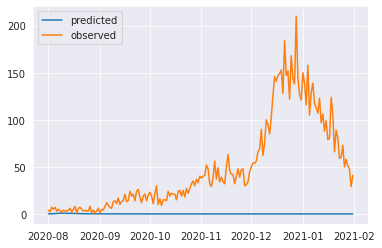

--------------------
Before Optimization
Metha epoch: 153
Linear Factors: [[ 0.00601445 -0.04903628 -0.36004013  0.3506562   0.00720938]]
 Bias: [0.09418186]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 153: 100%|██████████| 49/49 [00:02<00:00, 17.28it/s]


After Optimization
Metha epoch: 153
Linear Factors: [[ 0.30719495  0.2711955  -0.03990175  0.6634949   0.30697748]]
 Bias: [0.42434296]
 Alpha: 0.04871371015906334
 Phi: 24.883129119873047


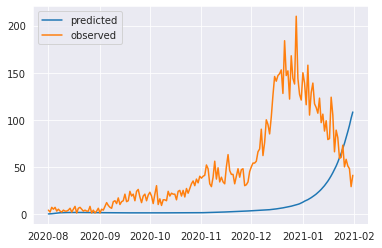

--------------------
Before Optimization
Metha epoch: 154
Linear Factors: [[-0.18059781 -0.20925978  0.07374085  0.16533975  0.10030911]]
 Bias: [-0.21553238]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 154:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 155
Linear Factors: [[ 0.43419868 -0.06583181 -0.27388033 -0.20916745  0.44024634]]
 Bias: [2.1538053e-05]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 155: 100%|██████████| 49/49 [00:02<00:00, 17.58it/s]


After Optimization
Metha epoch: 155
Linear Factors: [[0.73265123 0.2458156  0.03767147 0.09587648 0.7340855 ]]
 Bias: [0.31861052]
 Alpha: 0.04787931963801384
 Phi: 24.88191032409668


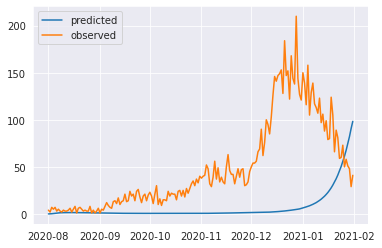

--------------------
Before Optimization
Metha epoch: 156
Linear Factors: [[-0.06070666 -0.18611321 -0.11723498 -0.37665606 -0.35539323]]
 Bias: [0.26174942]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 156:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 157
Linear Factors: [[ 0.38256863  0.4267761  -0.32286242  0.2418814  -0.27681026]]
 Bias: [0.26678985]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 157: 100%|██████████| 49/49 [00:02<00:00, 17.80it/s]


After Optimization
Metha epoch: 157
Linear Factors: [[ 0.5686978   0.6387346  -0.10856719  0.44523734 -0.09229196]]
 Bias: [0.496782]
 Alpha: 0.049512069672346115
 Phi: 24.885839462280273


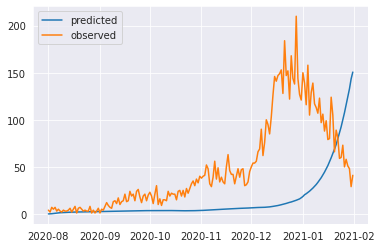

--------------------
Before Optimization
Metha epoch: 158
Linear Factors: [[0.32268888 0.3460856  0.32201672 0.27976486 0.00870441]]
 Bias: [0.20548679]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 158: 100%|██████████| 49/49 [00:02<00:00, 16.90it/s]


After Optimization
Metha epoch: 158
Linear Factors: [[0.41187313 0.45823127 0.43694618 0.38631913 0.09808306]]
 Bias: [0.3369065]
 Alpha: 0.04929472878575325
 Phi: 24.88506507873535


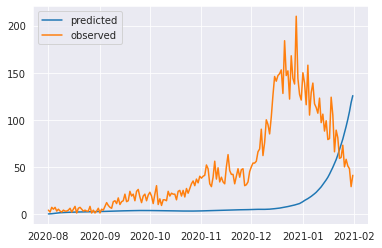

--------------------
Before Optimization
Metha epoch: 159
Linear Factors: [[-0.16000001  0.19473237 -0.14373532 -0.00750932 -0.38924524]]
 Bias: [-0.116935]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 159:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 160
Linear Factors: [[-0.23517753 -0.15085445 -0.28558457 -0.40224367  0.02912099]]
 Bias: [0.2902323]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 160: 100%|██████████| 49/49 [00:02<00:00, 17.17it/s]


After Optimization
Metha epoch: 160
Linear Factors: [[ 0.16327049  0.26801443  0.13180052 -0.00674515  0.43282935]]
 Bias: [0.7109175]
 Alpha: 0.048909991979599
 Phi: 24.88208770751953


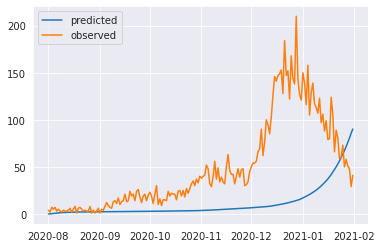

--------------------
Before Optimization
Metha epoch: 161
Linear Factors: [[ 0.40729952  0.26097333 -0.23180752 -0.4422986   0.1696343 ]]
 Bias: [0.25058]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 161: 100%|██████████| 49/49 [00:03<00:00, 15.38it/s]


After Optimization
Metha epoch: 161
Linear Factors: [[ 0.6586968   0.5325009   0.04091411 -0.17930834  0.41839945]]
 Bias: [0.5332242]
 Alpha: 0.049184758216142654
 Phi: 24.88389015197754


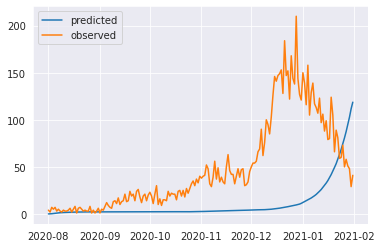

--------------------
Before Optimization
Metha epoch: 162
Linear Factors: [[-0.38393825  0.16036457  0.37810892  0.02709066 -0.26942778]]
 Bias: [0.36665982]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 162: 100%|██████████| 49/49 [00:03<00:00, 14.98it/s]


After Optimization
Metha epoch: 162
Linear Factors: [[-0.14684847  0.4180695   0.6370609   0.2766197  -0.03439529]]
 Bias: [0.6369533]
 Alpha: 0.049807604402303696
 Phi: 24.889389038085938


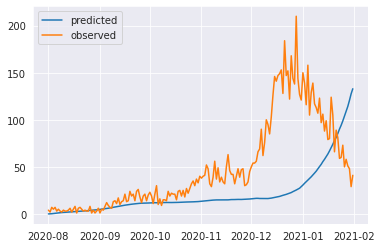

--------------------
Before Optimization
Metha epoch: 163
Linear Factors: [[ 0.19096732  0.29614535 -0.30244407  0.26025397 -0.30547982]]
 Bias: [0.4425153]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 163: 100%|██████████| 49/49 [00:03<00:00, 14.65it/s]


After Optimization
Metha epoch: 163
Linear Factors: [[ 0.35752663  0.4946318  -0.10085139  0.44932088 -0.13956375]]
 Bias: [0.6658569]
 Alpha: 0.04967144504189491
 Phi: 24.888769149780273


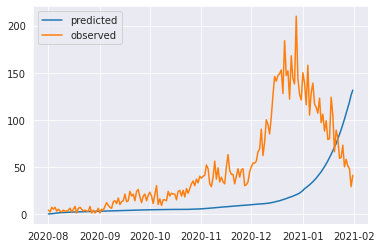

--------------------
Before Optimization
Metha epoch: 164
Linear Factors: [[-0.18948428  0.26947618  0.08955075  0.11851629 -0.06858244]]
 Bias: [0.18368644]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 164: 100%|██████████| 49/49 [00:03<00:00, 14.76it/s]


After Optimization
Metha epoch: 164
Linear Factors: [[0.05909866 0.539622   0.36108893 0.379948   0.17758052]]
 Bias: [0.46667713]
 Alpha: 0.049621641635894775
 Phi: 24.885637283325195


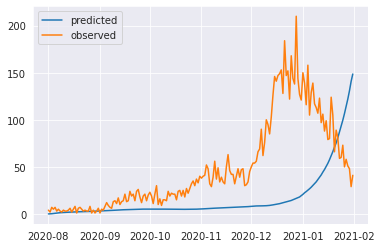

--------------------
Before Optimization
Metha epoch: 165
Linear Factors: [[-0.18638605 -0.42153427 -0.17182083  0.3504091  -0.11773777]]
 Bias: [0.14056747]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 165: 100%|██████████| 49/49 [00:03<00:00, 15.69it/s]


After Optimization
Metha epoch: 165
Linear Factors: [[ 0.1763067  -0.04471089  0.20511505  0.7217992   0.24415933]]
 Bias: [0.5229491]
 Alpha: 0.048550985753536224
 Phi: 24.882112503051758


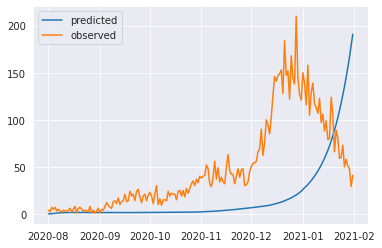

--------------------
Before Optimization
Metha epoch: 166
Linear Factors: [[-0.16534668  0.33547693  0.26765296  0.1578725  -0.22859845]]
 Bias: [-0.36543158]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 166: 100%|██████████| 49/49 [00:03<00:00, 15.52it/s]


After Optimization
Metha epoch: 166
Linear Factors: [[0.22312222 0.735112   0.66696656 0.547772   0.15722746]]
 Bias: [0.03267806]
 Alpha: 0.04830033332109451
 Phi: 24.881025314331055


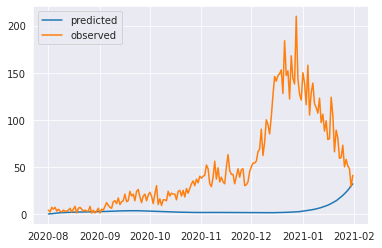

--------------------
Before Optimization
Metha epoch: 167
Linear Factors: [[ 0.01683732 -0.26236132  0.36769623 -0.4297614   0.19984558]]
 Bias: [0.4458335]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 167: 100%|██████████| 49/49 [00:03<00:00, 15.42it/s]


After Optimization
Metha epoch: 167
Linear Factors: [[ 0.23897178 -0.0172186   0.61440474 -0.1931842   0.42003417]]
 Bias: [0.7056976]
 Alpha: 0.04960440471768379
 Phi: 24.887086868286133


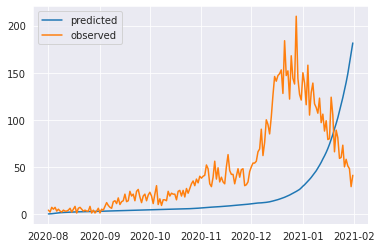

--------------------
Before Optimization
Metha epoch: 168
Linear Factors: [[ 0.22397725  0.15249033 -0.43028507  0.4301717  -0.0764948 ]]
 Bias: [-0.41788015]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 168:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 169
Linear Factors: [[ 0.44147262 -0.18198493 -0.03163929  0.40932542 -0.31000876]]
 Bias: [-0.31639913]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 169: 100%|██████████| 49/49 [00:03<00:00, 15.15it/s]


After Optimization
Metha epoch: 169
Linear Factors: [[ 0.4415442  -0.18193656 -0.03158905  0.4094221  -0.30994454]]
 Bias: [-0.31627315]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


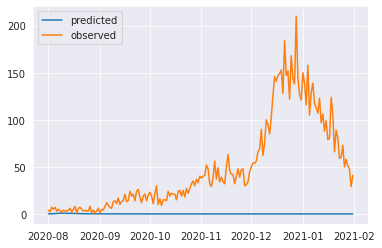

--------------------
Before Optimization
Metha epoch: 170
Linear Factors: [[ 0.07272468 -0.05986129  0.10301198 -0.3750804   0.01337465]]
 Bias: [-0.19890259]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 170:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 171
Linear Factors: [[-0.21985416 -0.40948525  0.23712085  0.08614966 -0.37809372]]
 Bias: [0.35488722]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 171: 100%|██████████| 49/49 [00:03<00:00, 14.53it/s]


After Optimization
Metha epoch: 171
Linear Factors: [[ 0.10652103 -0.06955107  0.57696617  0.41800725 -0.05480072]]
 Bias: [0.69881785]
 Alpha: 0.04940877482295036
 Phi: 24.884910583496094


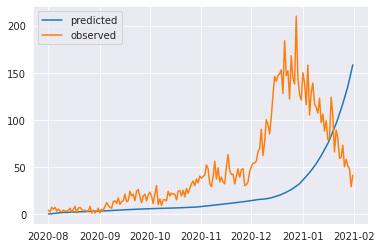

--------------------
Before Optimization
Metha epoch: 172
Linear Factors: [[ 0.13488893  0.08298638 -0.26257536  0.06744183  0.43090826]]
 Bias: [0.30673686]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 172: 100%|██████████| 49/49 [00:03<00:00, 15.40it/s]


After Optimization
Metha epoch: 172
Linear Factors: [[ 0.3027947   0.27820638 -0.06473295  0.25427118  0.5973483 ]]
 Bias: [0.52183765]
 Alpha: 0.04923513904213905
 Phi: 24.885082244873047


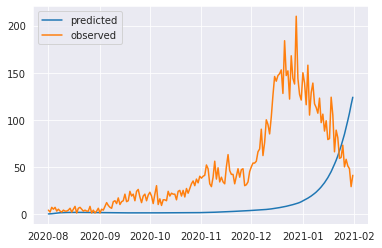

--------------------
Before Optimization
Metha epoch: 173
Linear Factors: [[-0.34832135  0.40822604  0.03466342  0.21509415  0.3473402 ]]
 Bias: [0.38125366]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 173: 100%|██████████| 49/49 [00:03<00:00, 14.96it/s]


After Optimization
Metha epoch: 173
Linear Factors: [[-0.23016238  0.5494078   0.17831178  0.3501711   0.46547592]]
 Bias: [0.5412311]
 Alpha: 0.04961085692048073
 Phi: 24.887741088867188


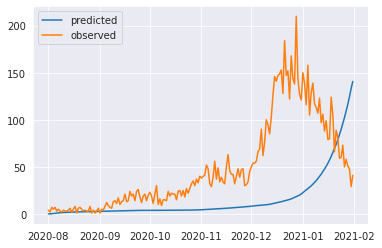

--------------------
Before Optimization
Metha epoch: 174
Linear Factors: [[-0.34861857  0.39160877 -0.30373624  0.03352585 -0.31249657]]
 Bias: [-0.0980441]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 174:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 175
Linear Factors: [[-0.02032259 -0.05350255 -0.07064898  0.03527198  0.44113985]]
 Bias: [0.25983626]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 175: 100%|██████████| 49/49 [00:04<00:00, 12.07it/s]


After Optimization
Metha epoch: 175
Linear Factors: [[0.18928997 0.17597316 0.16017824 0.25705886 0.64863014]]
 Bias: [0.5013295]
 Alpha: 0.04902307689189911
 Phi: 24.884662628173828


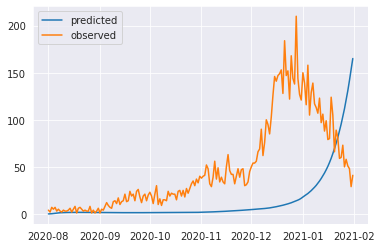

--------------------
Before Optimization
Metha epoch: 176
Linear Factors: [[ 0.25020257  0.1789961   0.3462243  -0.02063847  0.03555895]]
 Bias: [0.09203525]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 176: 100%|██████████| 49/49 [00:03<00:00, 16.03it/s]


After Optimization
Metha epoch: 176
Linear Factors: [[0.44789007 0.4004796  0.5696858  0.19229831 0.23110011]]
 Bias: [0.32896897]
 Alpha: 0.049466323107481
 Phi: 24.884639739990234


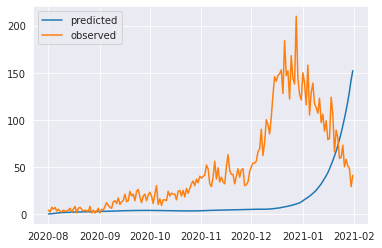

--------------------
Before Optimization
Metha epoch: 177
Linear Factors: [[-0.39002863 -0.360256    0.05482901 -0.17497243 -0.00820627]]
 Bias: [-0.1026171]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 177:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 178
Linear Factors: [[ 0.06961451  0.29096413 -0.14831477  0.35815576  0.35310274]]
 Bias: [-0.34323558]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 178: 100%|██████████| 49/49 [00:03<00:00, 16.23it/s]


After Optimization
Metha epoch: 178
Linear Factors: [[0.38856876 0.619979   0.18024547 0.68125635 0.6680612 ]]
 Bias: [-0.0113151]
 Alpha: 0.04751373454928398
 Phi: 24.881345748901367


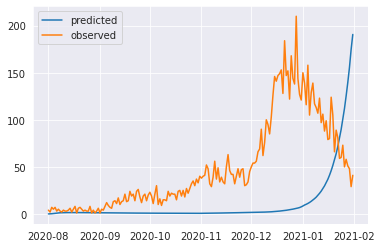

--------------------
Before Optimization
Metha epoch: 179
Linear Factors: [[-0.34535006 -0.36182928 -0.2450821  -0.17408964 -0.03366153]]
 Bias: [-0.10875885]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 179:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 180
Linear Factors: [[-0.22595401 -0.1420769  -0.16177706  0.4387336  -0.16575025]]
 Bias: [-0.32020533]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 180:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 181
Linear Factors: [[ 0.1859056  -0.02583175  0.3423706   0.27943364  0.41086802]]
 Bias: [-0.32752115]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 181: 100%|██████████| 49/49 [00:02<00:00, 16.48it/s]


After Optimization
Metha epoch: 181
Linear Factors: [[0.4514746  0.2522968  0.6214761  0.55092037 0.6727713 ]]
 Bias: [-0.04420353]
 Alpha: 0.04783714562654495
 Phi: 24.88184356689453


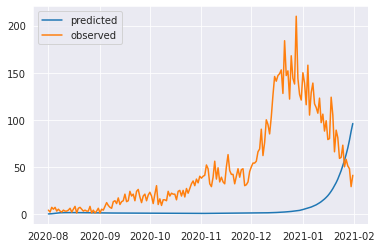

--------------------
Before Optimization
Metha epoch: 182
Linear Factors: [[ 0.28749725  0.37531897 -0.22084816  0.41106975  0.33525053]]
 Bias: [0.00489751]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 182: 100%|██████████| 49/49 [00:03<00:00, 15.52it/s]


After Optimization
Metha epoch: 182
Linear Factors: [[ 0.44805697  0.5566681  -0.03756436  0.5854817   0.4939769 ]]
 Bias: [0.20013462]
 Alpha: 0.048683762550354004
 Phi: 24.88347053527832


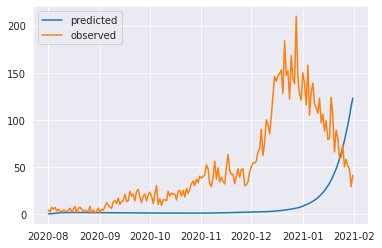

--------------------
Before Optimization
Metha epoch: 183
Linear Factors: [[ 0.21562514 -0.1563555  -0.39005244  0.11304668  0.13332567]]
 Bias: [-0.29228047]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 183:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 184
Linear Factors: [[ 0.21689844 -0.38201997  0.38488278  0.43307734  0.12175766]]
 Bias: [-0.28059468]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 184: 100%|██████████| 49/49 [00:02<00:00, 16.37it/s]


After Optimization
Metha epoch: 184
Linear Factors: [[ 0.52597064 -0.06447722  0.70354027  0.74546313  0.42557982]]
 Bias: [0.03857321]
 Alpha: 0.0468086376786232
 Phi: 24.881351470947266


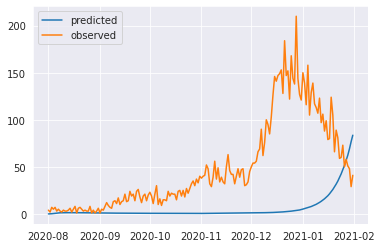

--------------------
Before Optimization
Metha epoch: 185
Linear Factors: [[0.21764597 0.07621224 0.12160577 0.14697824 0.34048852]]
 Bias: [-0.19222847]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 185: 100%|██████████| 49/49 [00:03<00:00, 15.40it/s]


After Optimization
Metha epoch: 185
Linear Factors: [[0.49374792 0.36414334 0.4095736  0.4278277  0.6136473 ]]
 Bias: [0.09907239]
 Alpha: 0.04804794490337372
 Phi: 24.881864547729492


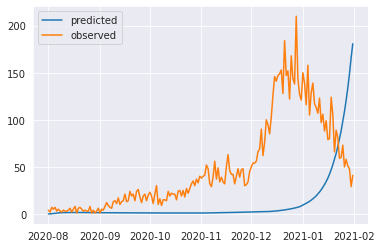

--------------------
Before Optimization
Metha epoch: 186
Linear Factors: [[-0.10059849  0.12195779  0.04872889  0.36062303 -0.2348938 ]]
 Bias: [-0.01628602]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 186: 100%|██████████| 49/49 [00:03<00:00, 16.07it/s]


After Optimization
Metha epoch: 186
Linear Factors: [[0.21688537 0.4519166  0.3786181  0.68287146 0.07943259]]
 Bias: [0.31690532]
 Alpha: 0.048982322216033936
 Phi: 24.882722854614258


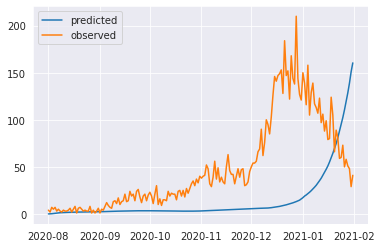

--------------------
Before Optimization
Metha epoch: 187
Linear Factors: [[ 0.08356328 -0.11877501  0.30487296  0.04891692 -0.4133282 ]]
 Bias: [-0.04844927]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 187: 100%|██████████| 49/49 [00:03<00:00, 15.75it/s]


After Optimization
Metha epoch: 187
Linear Factors: [[ 0.45839316  0.26815942  0.6919563   0.42783597 -0.04267916]]
 Bias: [0.34127674]
 Alpha: 0.049081724137067795
 Phi: 24.882205963134766


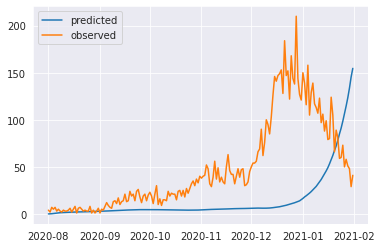

--------------------
Before Optimization
Metha epoch: 188
Linear Factors: [[-0.20283681  0.04345628 -0.05197335 -0.44360644 -0.08149365]]
 Bias: [-0.04283381]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 188:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 189
Linear Factors: [[-0.13187367  0.41089112 -0.09758162  0.2872977   0.11078274]]
 Bias: [-0.3775078]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 189:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 190
Linear Factors: [[ 0.10508896  0.37062183 -0.2925227  -0.28906766  0.4377546 ]]
 Bias: [0.35934058]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 190: 100%|██████████| 49/49 [00:03<00:00, 15.90it/s]


After Optimization
Metha epoch: 190
Linear Factors: [[ 0.28343305  0.5787816  -0.08142813 -0.08994975  0.6146618 ]]
 Bias: [0.58980334]
 Alpha: 0.04947586730122566
 Phi: 24.885650634765625


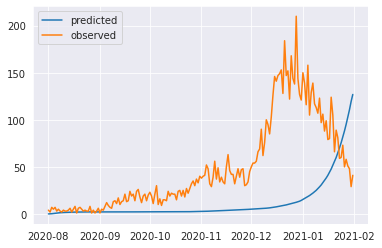

--------------------
Before Optimization
Metha epoch: 191
Linear Factors: [[-0.24949777  0.26910853 -0.05721296 -0.440921    0.0336007 ]]
 Bias: [0.14449203]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 191: 100%|██████████| 49/49 [00:02<00:00, 18.20it/s]


After Optimization
Metha epoch: 191
Linear Factors: [[ 0.12254326  0.65682894  0.330698   -0.06209535  0.4022539 ]]
 Bias: [0.53781843]
 Alpha: 0.04947441443800926
 Phi: 24.88286781311035


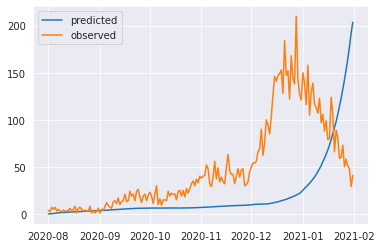

--------------------
Before Optimization
Metha epoch: 192
Linear Factors: [[-0.13414657  0.15557821 -0.38241273  0.30992615  0.38126493]]
 Bias: [0.2466234]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 192: 100%|██████████| 49/49 [00:02<00:00, 17.91it/s]


After Optimization
Metha epoch: 192
Linear Factors: [[ 0.0747281   0.3839153  -0.15276937  0.53061     0.5880168 ]]
 Bias: [0.48660308]
 Alpha: 0.048949941992759705
 Phi: 24.88473129272461


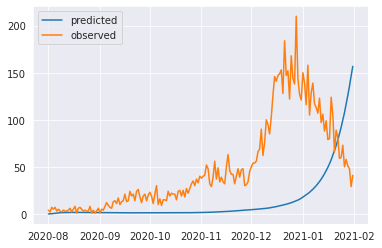

--------------------
Before Optimization
Metha epoch: 193
Linear Factors: [[ 0.07579881  0.14728932 -0.3235804  -0.11174678 -0.04269439]]
 Bias: [-0.24886817]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 193:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 194
Linear Factors: [[-0.33032092  0.30080372  0.30349937 -0.40615413  0.1423087 ]]
 Bias: [0.18192746]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 194: 100%|██████████| 49/49 [00:02<00:00, 17.87it/s]


After Optimization
Metha epoch: 194
Linear Factors: [[-0.04200527  0.6131341   0.6172979  -0.10386574  0.42778122]]
 Bias: [0.50837135]
 Alpha: 0.049772195518016815
 Phi: 24.885087966918945


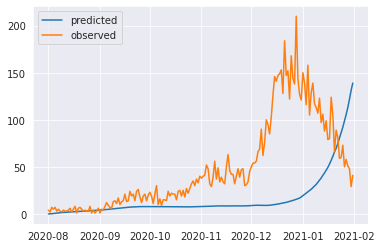

--------------------
Before Optimization
Metha epoch: 195
Linear Factors: [[ 0.42483875  0.25873706  0.41113985 -0.14641313  0.31322232]]
 Bias: [0.36376414]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 195: 100%|██████████| 49/49 [00:02<00:00, 18.14it/s]


After Optimization
Metha epoch: 195
Linear Factors: [[ 0.4690002   0.3340282   0.49069345 -0.07704427  0.35864517]]
 Bias: [0.46823293]
 Alpha: 0.04882894456386566
 Phi: 24.88457489013672


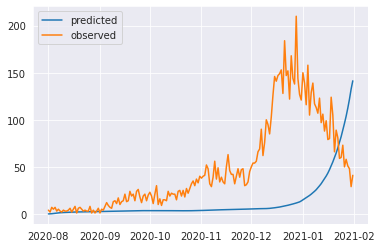

--------------------
Before Optimization
Metha epoch: 196
Linear Factors: [[-0.42231634 -0.35898134  0.09051847  0.24419552 -0.22218156]]
 Bias: [0.04925364]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 196:   0%|          | 0/49 [00:00<?, ?it/s]


Gradient is zero
--------------------
Before Optimization
Metha epoch: 197
Linear Factors: [[-0.00064923  0.11319319 -0.24031003  0.2522459   0.29740122]]
 Bias: [-0.31030285]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 197: 100%|██████████| 49/49 [00:02<00:00, 18.71it/s]


After Optimization
Metha epoch: 197
Linear Factors: [[-0.00059707  0.11323121 -0.24028267  0.25231764  0.29746437]]
 Bias: [-0.3101969]
 Alpha: 0.029464930295944214
 Phi: 24.8800048828125


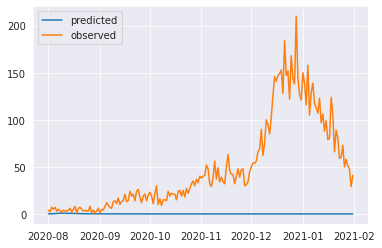

--------------------
Before Optimization
Metha epoch: 198
Linear Factors: [[0.00433235 0.00124084 0.14360732 0.41661724 0.1311514 ]]
 Bias: [-0.10161675]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 198: 100%|██████████| 49/49 [00:02<00:00, 17.96it/s]


After Optimization
Metha epoch: 198
Linear Factors: [[0.26536578 0.2820533  0.4256917  0.6892209  0.38965505]]
 Bias: [0.19060846]
 Alpha: 0.04883800074458122
 Phi: 24.88315773010254


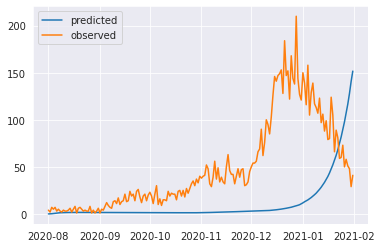

--------------------
Before Optimization
Metha epoch: 199
Linear Factors: [[ 0.40165725 -0.17017947 -0.12985821  0.03053366 -0.3405571 ]]
 Bias: [0.04866459]
 Alpha: 0.027999991551041603
 Phi: 25.0



Meta Epoch 199: 100%|██████████| 49/49 [00:02<00:00, 18.61it/s]


After Optimization
Metha epoch: 199
Linear Factors: [[0.7568789  0.19854935 0.23880368 0.39120644 0.00955085]]
 Bias: [0.42327732]
 Alpha: 0.04877281188964844
 Phi: 24.882129669189453


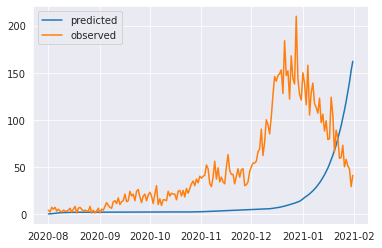

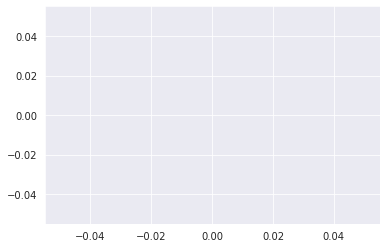

In [221]:
from tqdm import tqdm
meta_epoch_params = {}
loss_development = {}
for meta_epoch in range(200):
    print('-'*20)
    method = Linear(device=device, dtype=dtype, input_size=input_data_size)

    dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
    #dict_param['real_values']['alpha'] = torch.tensor(exp_parameters.describe()['alpha']['50%'], requires_grad=False, device=device, dtype=dtype)
    #dict_param['real_values']['phi'] = torch.tensor(exp_parameters.describe()['phi']['50%'], requires_grad=False, device=device, dtype=dtype)

    params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi'], dict_param['prime_values']['alpha']]
    optimizer = optim.Adam(params_to_be_optimized, lr=0.01)

    loss_development[meta_epoch] = []

    with torch.no_grad():
        print('Before Optimization')
        print(f'Metha epoch: {meta_epoch}\n'
              f'Linear Factors: {method.get_parameters()[0].detach().numpy()}\n',
              f'Bias: {method.get_parameters()[1].detach().numpy()}\n',
              f'Alpha: {dict_param["real_values"]["alpha"]}\n',
              f'Phi: {dict_param["real_values"]["phi"]}\n')

    for i in tqdm(range(1, 50), desc='Meta Epoch {}'.format(meta_epoch)):
        iteration_time = time.time()
        optimizer.zero_grad()

        # transform alphi, phi
        dict_param = transform_prime_variables(dict_param)

        # forward pass
        expected = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

        # calc loss
        comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi'] #calc_negative_binomnial_loss(expected, observed_train, dict_param['real_values']['phi']) #
        method_loss = method.calculate_loss()
        model_param_loss = calc_prior_loss(dict_param, device, dtype)
        loss = comparison_loss_train + method_loss + model_param_loss

        loss_development[meta_epoch].append(loss.item())

        # backward pass
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            if params_to_be_optimized[1].grad.detach().numpy()[0] == 0:
                print('Gradient is zero')
                break

    if params_to_be_optimized[1].grad.detach().numpy()[0] == 0:
        continue



    with torch.no_grad():

        meta_epoch_params[meta_epoch] = (method.get_parameters(), loss, dict_param["real_values"]["alpha"].detach().numpy(), dict_param["real_values"]["phi"].detach().numpy())
        print('After Optimization')
        print(f'Metha epoch: {meta_epoch}\n'
              f'Linear Factors: {method.get_parameters()[0].detach().numpy()}\n',
              f'Bias: {method.get_parameters()[1].detach().numpy()}\n',
              f'Alpha: {dict_param["real_values"]["alpha"]}\n',
              f'Phi: {dict_param["real_values"]["phi"]}')
        plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
        plt.plot(df_obs['Date'], observed_train.cpu().detach().numpy(), label='observed')
        plt.legend()
        plt.show()
        plt.plot()

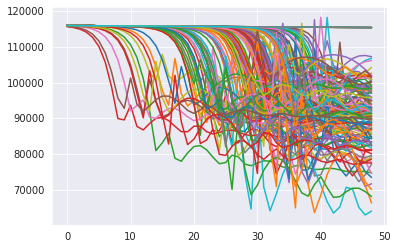

In [222]:
for i in loss_development.keys():
    plt.plot(loss_development[i])
plt.show()

In [223]:
f0 = [meta_epoch_params[i][0][0].detach().numpy()[0][0] for i in meta_epoch_params.keys()]
f1 = [meta_epoch_params[i][0][0].detach().numpy()[0][1] for i in meta_epoch_params.keys()]
f2 = [meta_epoch_params[i][0][0].detach().numpy()[0][2] for i in meta_epoch_params.keys()]
f3 = [meta_epoch_params[i][0][0].detach().numpy()[0][3] for i in meta_epoch_params.keys()]
f4 = [meta_epoch_params[i][0][0].detach().numpy()[0][4] for i in meta_epoch_params.keys()]
b = [meta_epoch_params[i][0][1].detach().numpy()[0] for i in meta_epoch_params.keys()]
alpha = [meta_epoch_params[i][2] for i in meta_epoch_params.keys()]
phi = [meta_epoch_params[i][3] for i in meta_epoch_params.keys()]
loss_param = [float(meta_epoch_params[i][1].detach().numpy()) for i in meta_epoch_params.keys()]

In [224]:
alpha[0].item()

0.048722028732299805

In [225]:
params_dist_df = pd.DataFrame({'f0': f0, 'f1': f1, 'f2': f2, 'f3': f3, 'f4': f4, 'b': b, 'alpha': [x.item() for x in alpha], 'phi': [x.item() for x in phi], 'loss': loss_param})

In [226]:
params_dist_df = params_dist_df[params_dist_df['loss']<60000]

<AxesSubplot:>

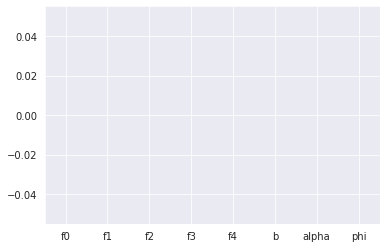

In [227]:
params_dist_df.boxplot(column=['f0', 'f1', 'f2', 'f3', 'f4', 'b', 'alpha', 'phi'])

In [228]:
params_parallel_df = params_dist_df - params_dist_df.quantile(0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


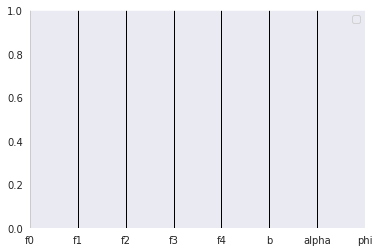

In [229]:
# libraries

import matplotlib.pyplot as plt

# Take the iris dataset
import seaborn as sns

# Make the plot
pd.plotting.parallel_coordinates(params_parallel_df, 'loss', colormap=plt.get_cmap("Set2"))
plt.show()